Imports

In [1]:
import torch
torch.cuda.empty_cache()


In [2]:
# imports for the tutorial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision

# sklearn imports
from sklearn.manifold import TSNE


import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import time

Reparametrization trick 

In [3]:
# reparametrization trick
def reparameterize(mu, logvar, device=torch.device("cpu")):
    """
    This function applies the reparameterization trick:
    z = mu(X) + sigma(X)^0.5 * epsilon, where epsilon ~ N(0,I)
    :param mu: mean of x
    :param logvar: log variance of x
    :param device: device to perform calculations on
    :return z: the sampled latent variable
    """
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std).to(device)
    return mu + eps * std

Prepare Data

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Dataset
def load_data(img_dir):
    x_data = []
    image_paths = [os.path.join(img_dir, w) for w in os.listdir(img_dir) if w.endswith(('.png', '.jpg', '.jpeg'))]
    for image_path in tqdm(image_paths):
        img = Image.open(image_path).convert('L')  # Load image in grayscale
        img = img.resize((128, 128))  # Ensure image is 128x128
        x_data.append(np.array(img))
    return np.array(x_data)

# Prepare Data
data = load_data("/home/thumbnails128x128")
data = data.astype('float32')/255

# Add channel dimension
data = data[..., np.newaxis]

# Convert to Tensors and permute to match the expected shape [batch_size, channels, height, width]
data_tensor = torch.tensor(data).float().permute(0, 3, 1, 2).to(device)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Calculate the sizes of each split
total_size = len(data_tensor)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size

# Shuffle the dataset
indices = torch.randperm(total_size).tolist()

# Split indices for each dataset
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Create TensorDataset from shuffled data
train_dataset = TensorDataset(data_tensor[train_indices], data_tensor[train_indices])
val_dataset = TensorDataset(data_tensor[val_indices], data_tensor[val_indices])
test_dataset = TensorDataset(data_tensor[test_indices], data_tensor[test_indices])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print the sizes of each dataset
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Using device: cuda


  1%|          | 724/70000 [00:00<00:28, 2414.44it/s]

100%|██████████| 70000/70000 [00:28<00:00, 2424.98it/s]


Training set size: 49000
Validation set size: 14000
Test set size: 7000


Training set images:


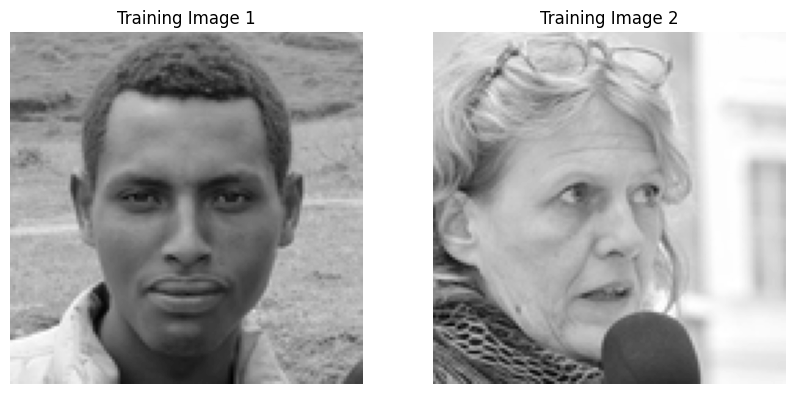

Validation set images:


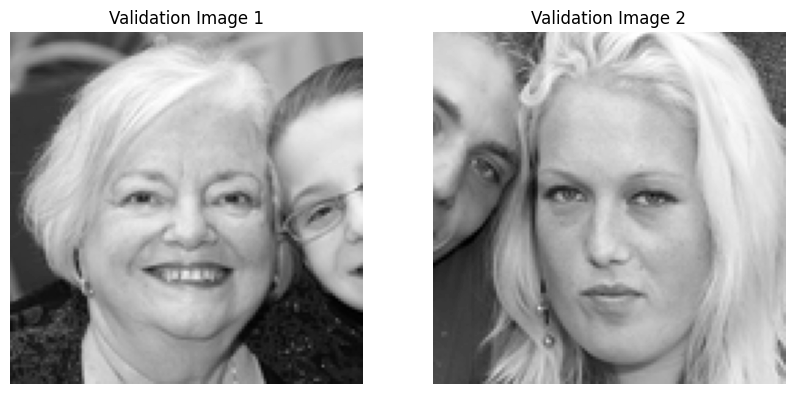

Test set images:


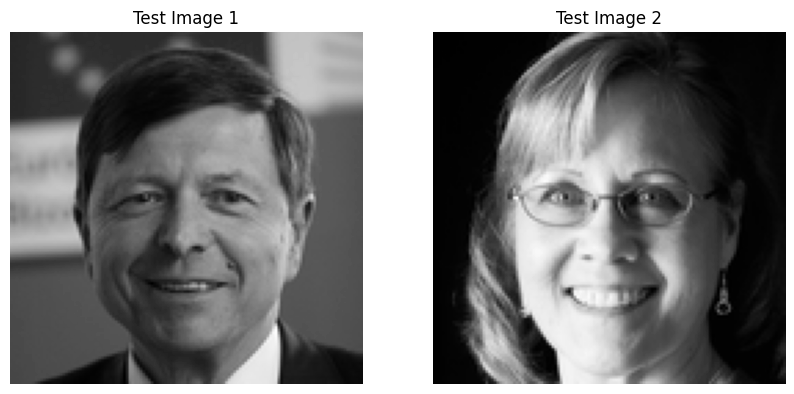

In [5]:
import torch
import matplotlib.pyplot as plt

# Function to display images
def show_images(images, title):
    plt.figure(figsize=(10, 5))
    for i in range(2):  # Display two images
        plt.subplot(1, 2, i + 1)
        img = images[i].cpu().numpy().squeeze()  # Remove channel dimension
        plt.imshow(img, cmap='gray')  # Use grayscale colormap
        plt.title(f'{title} Image {i + 1}')
        plt.axis('off')
    plt.show()

# Function to display images from a DataLoader
def display_images_from_loader(loader, title):
    data_iter = iter(loader)
    images, _ = next(data_iter)
    show_images(images, title)

# Display images from each data loader
print("Training set images:")
display_images_from_loader(train_loader, 'Training')

print("Validation set images:")
display_images_from_loader(val_loader, 'Validation')

print("Test set images:")
display_images_from_loader(test_loader, 'Test')


Architecture

In [6]:
class VaeEncoder(nn.Module):
    """
    This class builds the encoder for the VAE
    :param x_dim: input dimensions
    :param hidden_size: hidden layer size
    :param z_dim: latent dimensions
    :param device: cpu or gpu
    """

    def __init__(self, x_dim=128*128, hidden_size=512, z_dim=200, device=torch.device("cpu")):
        super(VaeEncoder, self).__init__()
        self.x_dim = x_dim
        self.hidden_size = hidden_size
        self.z_dim = z_dim
        self.device = device
        
        self.features = nn.Sequential(nn.Linear(x_dim, self.hidden_size),
                                      nn.ReLU())
        
        self.fc1 = nn.Linear(self.hidden_size, self.z_dim, bias=True)  # fully-connected to output mu
        self.fc2 = nn.Linear(self.hidden_size, self.z_dim, bias=True)  # fully-connected to output logvar

    def bottleneck(self, h):
        """
        This function takes features from the encoder and outputs mu, log-var and a latent space vector z
        :param h: features from the encoder
        :return: z, mu, log-variance
        """
        mu, logvar = self.fc1(h), self.fc2(h)
        # use the reparametrization trick as torch.normal(mu, logvar.exp()) is not differentiable
        z = reparameterize(mu, logvar, device=self.device)
        return z, mu, logvar

    def forward(self, x):
        """
        This is the function called when doing the forward pass:
        z, mu, logvar = VaeEncoder(X)
        """
        h = self.features(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar


In [7]:
class VaeDecoder(nn.Module):
    """
    This class builds the decoder for the VAE
    :param x_dim: input dimensions
    :param hidden_size: hidden layer size
    :param z_dim: latent dimensions
    """

    def __init__(self, x_dim=128*128, hidden_size=512, z_dim=200):
        super(VaeDecoder, self).__init__()
        self.x_dim = x_dim
        self.hidden_size = hidden_size
        self.z_dim = z_dim
        
        self.decoder = nn.Sequential(nn.Linear(self.z_dim, self.hidden_size),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_size, self.x_dim),
                                     nn.Sigmoid())
        # why we use sigmoid? because the pixel values of images are in [0,1] and sigmoid(x) does just that!
        # however, you don't have to use that (see what happens without it).

    def forward(self, x):
        """
        This is the function called when doing the forward pass:
        x_reconstruction = VaeDecoder(z)
        """
        x = self.decoder(x)
        return x


In [8]:
class Vae(nn.Module):
    def __init__(self, x_dim=128*128, z_dim=200, hidden_size=512, device=torch.device("cpu")):
        super(Vae, self).__init__()
        self.device = device
        self.z_dim = z_dim

        self.encoder = VaeEncoder(x_dim, hidden_size, z_dim=z_dim, device=device)
        self.decoder = VaeDecoder(x_dim, hidden_size, z_dim=z_dim)

    def encode(self, x):
        z, mu, logvar = self.encoder(x)
        return z, mu, logvar

    def decode(self, z):
        x = self.decoder(z)
        return x

    def sample(self, num_samples=1):
        """
        This function generates new data by sampling random variables and decoding them.
        Vae.sample() actually generates new data!
        Sample z ~ N(0,1)
        """
        z = torch.randn(num_samples, self.z_dim).to(self.device)
        return self.decode(z)

    def forward(self, x):
        """
        This is the function called when doing the forward pass:
        return x_recon, mu, logvar, z = Vae(X)
        """
        z, mu, logvar = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z


Loss function

In [9]:

def loss_function(recon_x, x, mu, logvar, model, loss_type='mse', lambda_l1=0.0, lambda_l2=0.0, use_l1=False, use_l2=False):
    """
    This function calculates the loss of the VAE with optional L1 and L2 regularization.
    
    Loss = reconstruction_loss + KL-divergence + regularization_loss
    
    :param recon_x: the reconstruction from the decoder
    :param x: the original input
    :param mu: the mean given X, from the encoder
    :param logvar: the log-variance given X, from the encoder
    :param model: the model used to calculate regularization loss
    :param loss_type: type of reconstruction loss function - 'mse', 'l1', 'bce'
    :param lambda_l1: coefficient for L1 regularization
    :param lambda_l2: coefficient for L2 regularization
    :param use_l1: boolean flag to apply L1 regularization
    :param use_l2: boolean flag to apply L2 regularization
    :return: VAE loss
    """
    # Compute reconstruction loss
    if loss_type == 'mse':
        recon_error = F.mse_loss(recon_x, x, reduction='sum')
    elif loss_type == 'l1':
        recon_error = F.l1_loss(recon_x, x, reduction='sum')
    elif loss_type == 'bce':
        recon_error = F.binary_cross_entropy(recon_x, x, reduction='sum')
    else:
        raise NotImplementedError(f"Loss type '{loss_type}' not implemented")

    # Compute KL-divergence loss
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Compute regularization loss
    reg_terms = 0.0
    if use_l1 and lambda_l1 > 0:
        reg_terms += lambda_l1 * sum(p.abs().sum() for p in model.decoder.parameters())
    if use_l2 and lambda_l2 > 0:
        reg_terms += lambda_l2 * sum(p.pow(2.0).sum() for p in model.decoder.parameters())
    
    # Total loss
    total_loss = recon_error + kl + reg_terms
    
    return total_loss / x.size(0)  # Normalize by batch size


hyperparameters

In [10]:
# define hyper-parameters
BATCH_SIZE = 128  # usually 32/64/128/256
LEARNING_RATE = 1e-3  # for the gradient optimizer
NUM_EPOCHS = 200  # how many epochs to run?
HIDDEN_SIZE = 512  # size of the hidden layers in the networks
X_DIM = 128 * 128  # size of the input dimension
Z_DIM = 200  # size of the latent dimension

Training Loop + plots

Epoch: 0 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 750.07143 | Validation Loss: 601.66384 | Time: 1.221 sec
Epoch: 1 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 591.49806 | Validation Loss: 574.63273 | Time: 1.128 sec
Epoch: 2 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 570.67494 | Validation Loss: 558.17069 | Time: 1.131 sec
Epoch: 3 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 560.94348 | Validation Loss: 553.83708 | Time: 1.145 sec
Epoch: 4 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 556.57849 | Validation Loss: 550.76950 | Time: 1.149 sec
Epoch: 5 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 554.14604 | Validation Lo

Epoch: 8 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 549.70057 | Validation Loss: 545.86722 | Time: 1.115 sec
Epoch: 9 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 548.83470 | Validation Loss: 543.83509 | Time: 1.159 sec
Epoch: 10 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 548.49879 | Validation Loss: 544.76626 | Time: 1.174 sec
Epoch: 11 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 547.59525 | Validation Loss: 545.92484 | Time: 1.151 sec
Epoch: 12 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 546.83349 | Validation Loss: 543.73066 | Time: 1.181 sec
Epoch: 13 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 546.46034 | Validatio

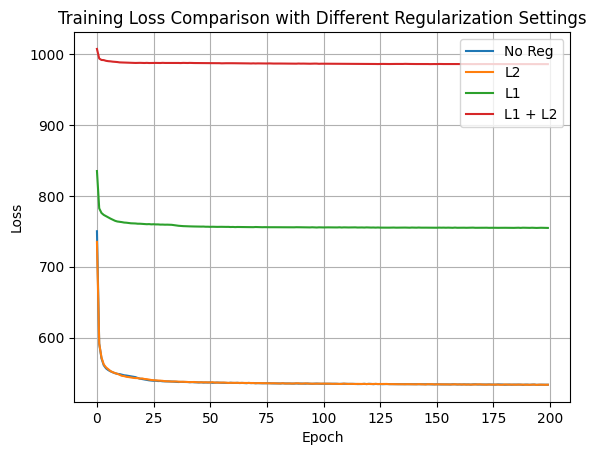

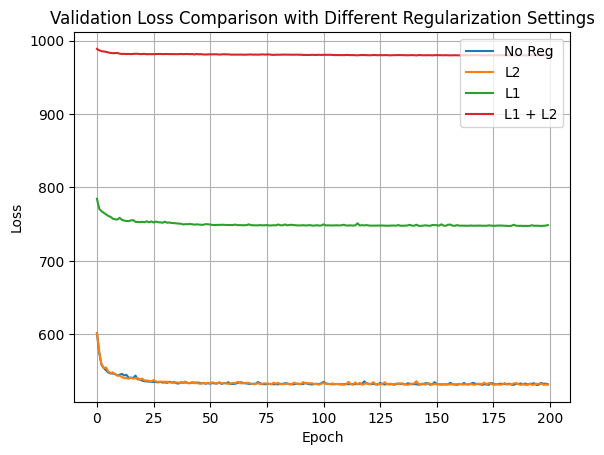

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from torch.utils.data import DataLoader

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize variables for tracking loss
regularization_settings = [
    {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False},
    {'lambda_l1': 0.0, 'lambda_l2': 1e-05, 'use_l1': False, 'use_l2': True},
    {'lambda_l1': 1e-05, 'lambda_l2': 0.0, 'use_l1': True, 'use_l2': False},
    {'lambda_l1': 1e-05, 'lambda_l2': 1e-05, 'use_l1': True, 'use_l2': True},
]

# Create lists to store training and validation losses for each regularization setting
all_train_losses = {}
all_val_losses = {}
best_val_loss = {}
best_model_state = {}

# Loop through each regularization setting
for reg_settings in regularization_settings:
    # Create model and optimizer
    vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
    vae_optim = torch.optim.Adam(params=vae.parameters(), lr=LEARNING_RATE)
    vae.train()
    
    # Generate label for this setting
    label = f"$\\lambda_{{L1}} = {reg_settings['lambda_l1']}, \\lambda_{{L2}} = {reg_settings['lambda_l2']}$"

    # Store losses for this setting
    train_losses = []
    val_losses = []
    
    # Initialize best validation loss as infinity
    best_val_loss[label] = float('inf')

    # Training loop
    for epoch in range(NUM_EPOCHS):
        epoch_start_time = time.time()
        batch_train_losses = []
        batch_val_losses = []

        # Training
        for batch in train_loader:
            x = batch[0].to(device).view(-1, X_DIM)  # just the images
            x_recon, mu, logvar, z = vae(x)
            # Calculate the loss with current regularization settings
            loss = loss_function(x_recon, x, mu, logvar, model=vae,
                                 lambda_l1=reg_settings['lambda_l1'],
                                 lambda_l2=reg_settings['lambda_l2'],
                                 use_l1=reg_settings['use_l1'],
                                 use_l2=reg_settings['use_l2'])
            # Optimization
            vae_optim.zero_grad()
            loss.backward()
            vae_optim.step()
            batch_train_losses.append(loss.data.cpu().item())

        # Validation
        vae.eval()
        with torch.no_grad():
            for batch in val_loader:
                x = batch[0].to(device).view(-1, X_DIM)
                x_recon, mu, logvar, z = vae(x)
                val_loss = loss_function(x_recon, x, mu, logvar, model=vae,
                                         lambda_l1=reg_settings['lambda_l1'],
                                         lambda_l2=reg_settings['lambda_l2'],
                                         use_l1=reg_settings['use_l1'],
                                         use_l2=reg_settings['use_l2'])
                batch_val_losses.append(val_loss.data.cpu().item())

        train_losses.append(np.mean(batch_train_losses))
        val_losses.append(np.mean(batch_val_losses))

        # Check if current validation loss is the best we've seen
        if val_losses[-1] < best_val_loss[label]:
            best_val_loss[label] = val_losses[-1]
            best_model_state[label] = vae.state_dict()

        print("Epoch: {} | Regularization: {} | Training Loss: {:.5f} | Validation Loss: {:.5f} | Time: {:.3f} sec".format(
            epoch, reg_settings, train_losses[-1], val_losses[-1], time.time() - epoch_start_time
        ))
    
    # Store losses for this regularization setting
    all_train_losses[label] = train_losses
    all_val_losses[label] = val_losses

    # Save the best model for this regularization setting
    best_model_path = f"./vae_best_{str(reg_settings)}.pth"
    torch.save(best_model_state[label], best_model_path)
    print(f"Best model for {label} saved at {best_model_path} with val loss {best_val_loss[label]:.4f}")

# Plot training losses with custom legend labels

for label, train_losses in all_train_losses.items():
    if label == r"$\lambda_{L1} = 0.0, \lambda_{L2} = 0.0$":
        plt.plot(train_losses, label='No Reg')
    elif label == r"$\lambda_{L1} = 0.0, \lambda_{L2} = 1e-05$":
        plt.plot(train_losses, label='L2')
    elif label == r"$\lambda_{L1} = 1e-05, \lambda_{L2} = 0.0$":
        plt.plot(train_losses, label='L1')
    elif label == r"$\lambda_{L1} = 1e-05, \lambda_{L2} = 1e-05$":
        plt.plot(train_losses, label='L1 + L2')

# Add title and labels for training losses
plt.title('Training Loss Comparison with Different Regularization Settings')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


# Plot validation losses with custom legend labels
for label, val_losses in all_val_losses.items():
    if label == r"$\lambda_{L1} = 0.0, \lambda_{L2} = 0.0$":
        plt.plot(val_losses, label='No Reg')
    elif label == r"$\lambda_{L1} = 0.0, \lambda_{L2} = 1e-05$":
        plt.plot(val_losses, label='L2')
    elif label == r"$\lambda_{L1} = 1e-05, \lambda_{L2} = 0.0$":
        plt.plot(val_losses, label='L1')
    elif label == r"$\lambda_{L1} = 1e-05, \lambda_{L2} = 1e-05$":
        plt.plot(val_losses, label='L1 + L2')

# Add title and labels for validation losses
plt.title('Validation Loss Comparison with Different Regularization Settings')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


Evaluation Matrices

Loaded checkpoint from ./vae_best_{'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False}.pth


Model Path: ./vae_best_{'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False}.pth
Length of MSE list: 7000
Length of SSIM list: 7000
Length of PSNR list: 7000


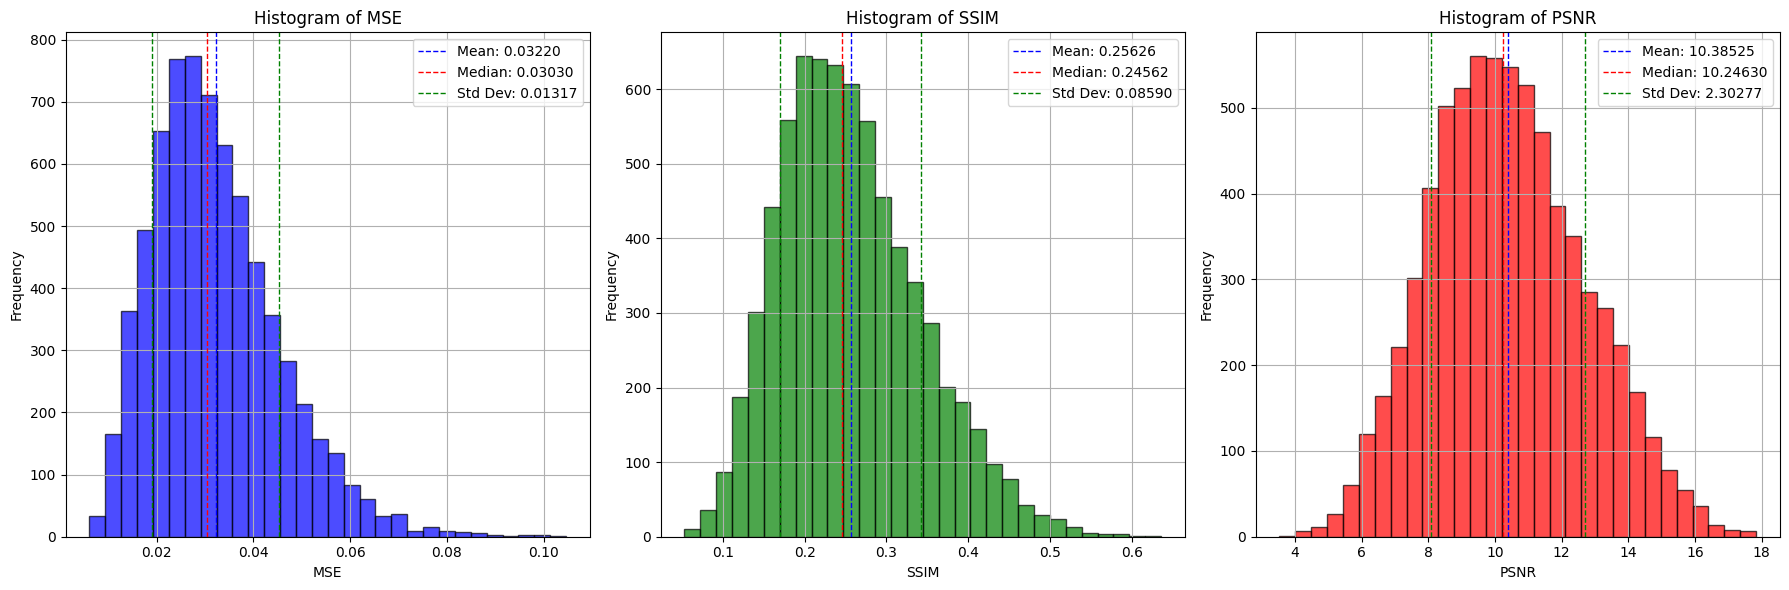

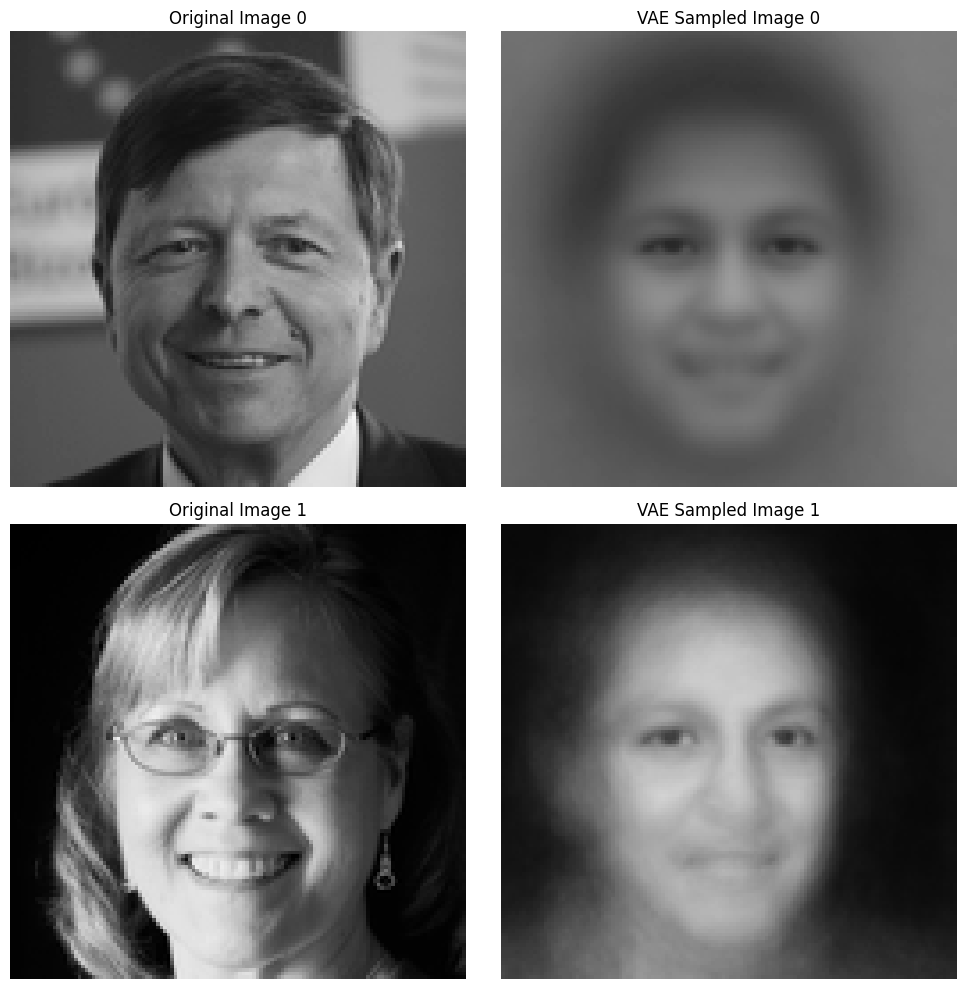

Loaded checkpoint from ./vae_best_{'lambda_l1': 0.0, 'lambda_l2': 1e-05, 'use_l1': False, 'use_l2': True}.pth
Model Path: ./vae_best_{'lambda_l1': 0.0, 'lambda_l2': 1e-05, 'use_l1': False, 'use_l2': True}.pth
Length of MSE list: 7000
Length of SSIM list: 7000
Length of PSNR list: 7000


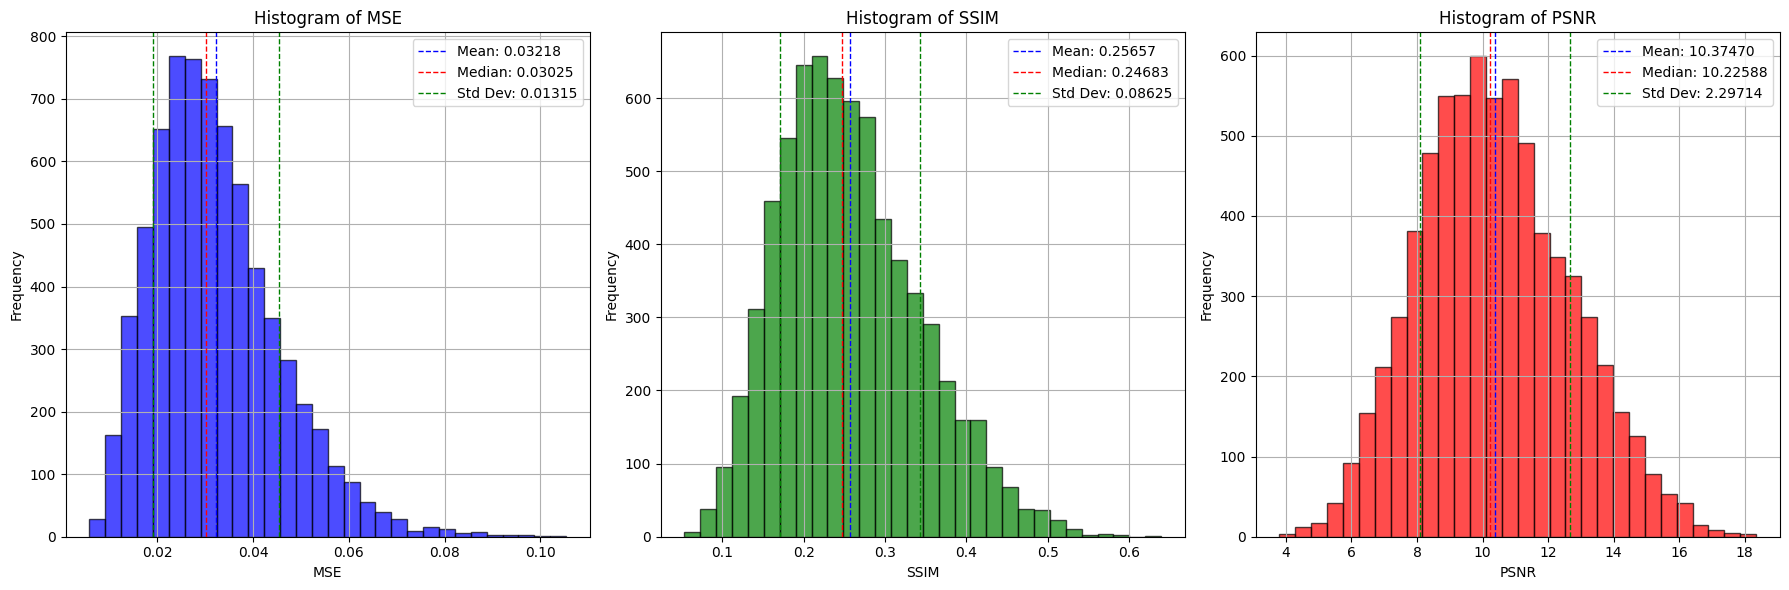

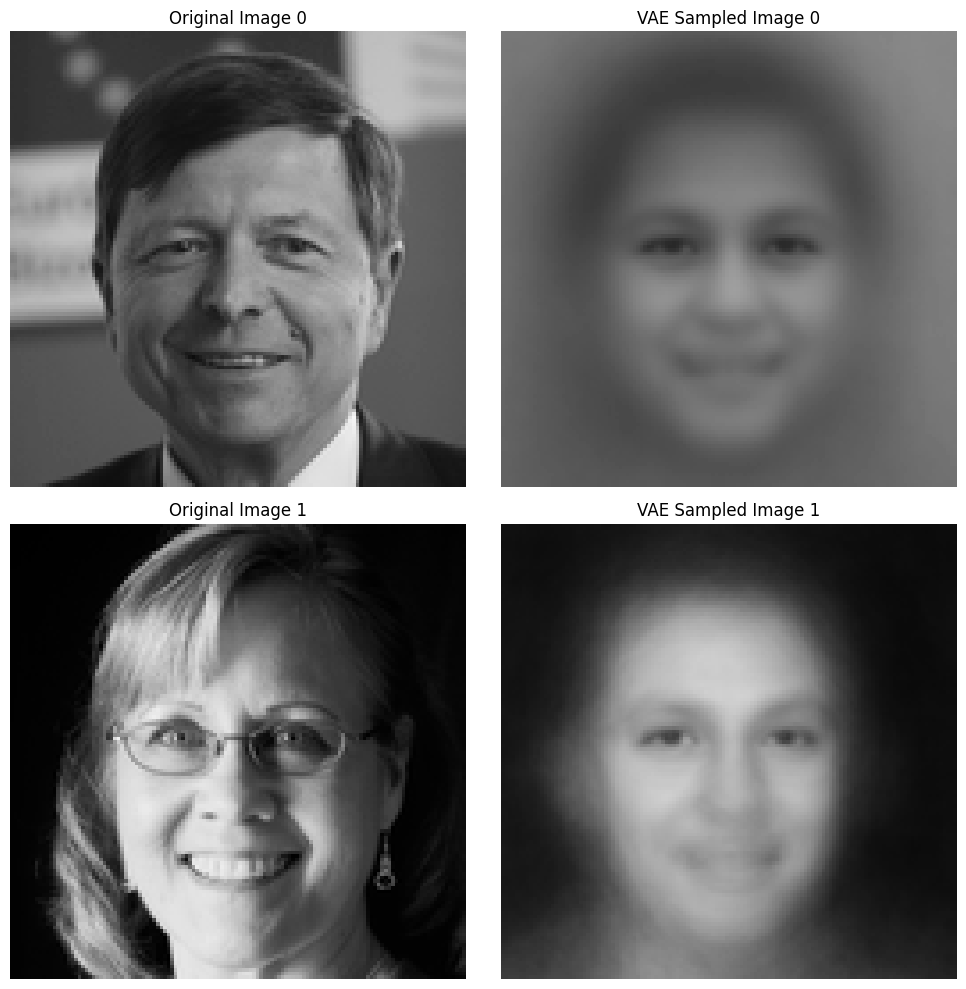

Loaded checkpoint from ./vae_best_{'lambda_l1': 1e-05, 'lambda_l2': 0.0, 'use_l1': True, 'use_l2': False}.pth
Model Path: ./vae_best_{'lambda_l1': 1e-05, 'lambda_l2': 0.0, 'use_l1': True, 'use_l2': False}.pth
Length of MSE list: 7000
Length of SSIM list: 7000
Length of PSNR list: 7000


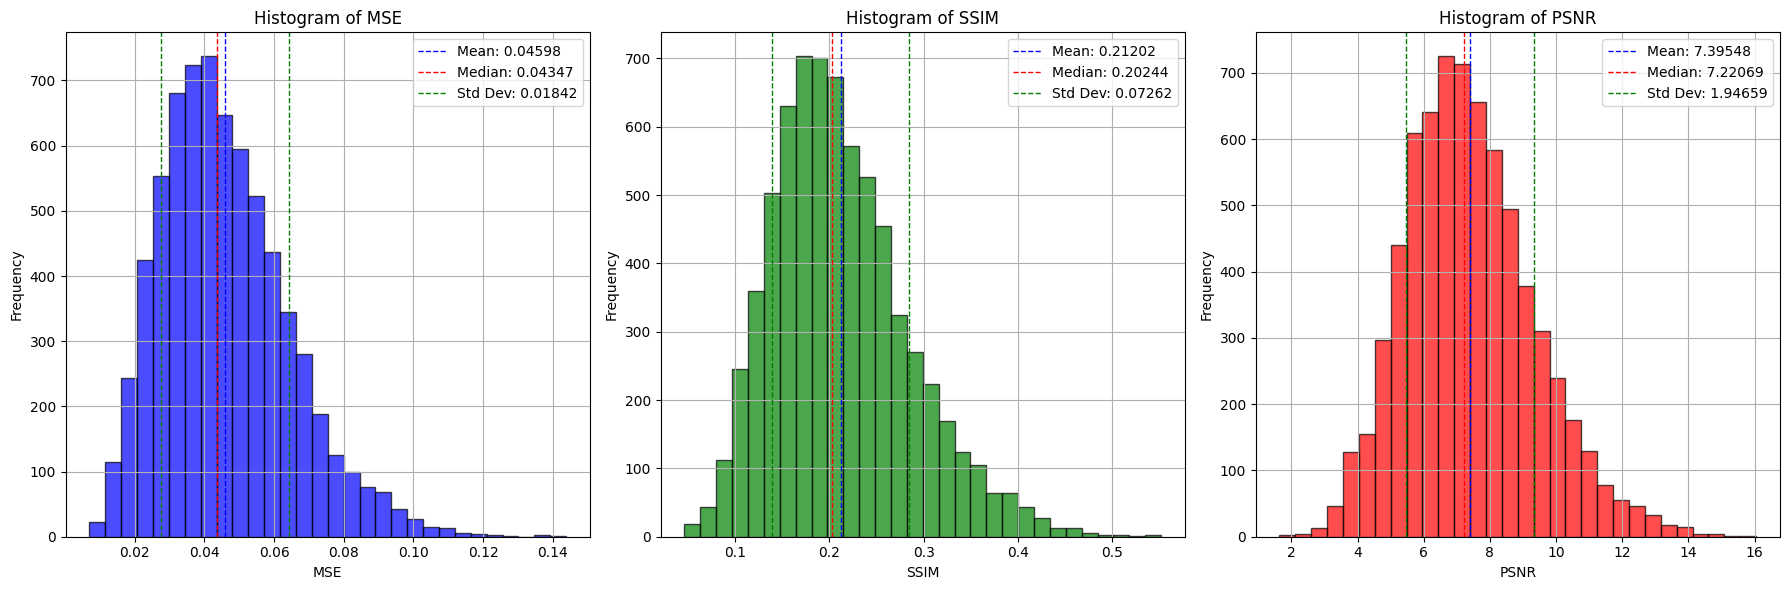

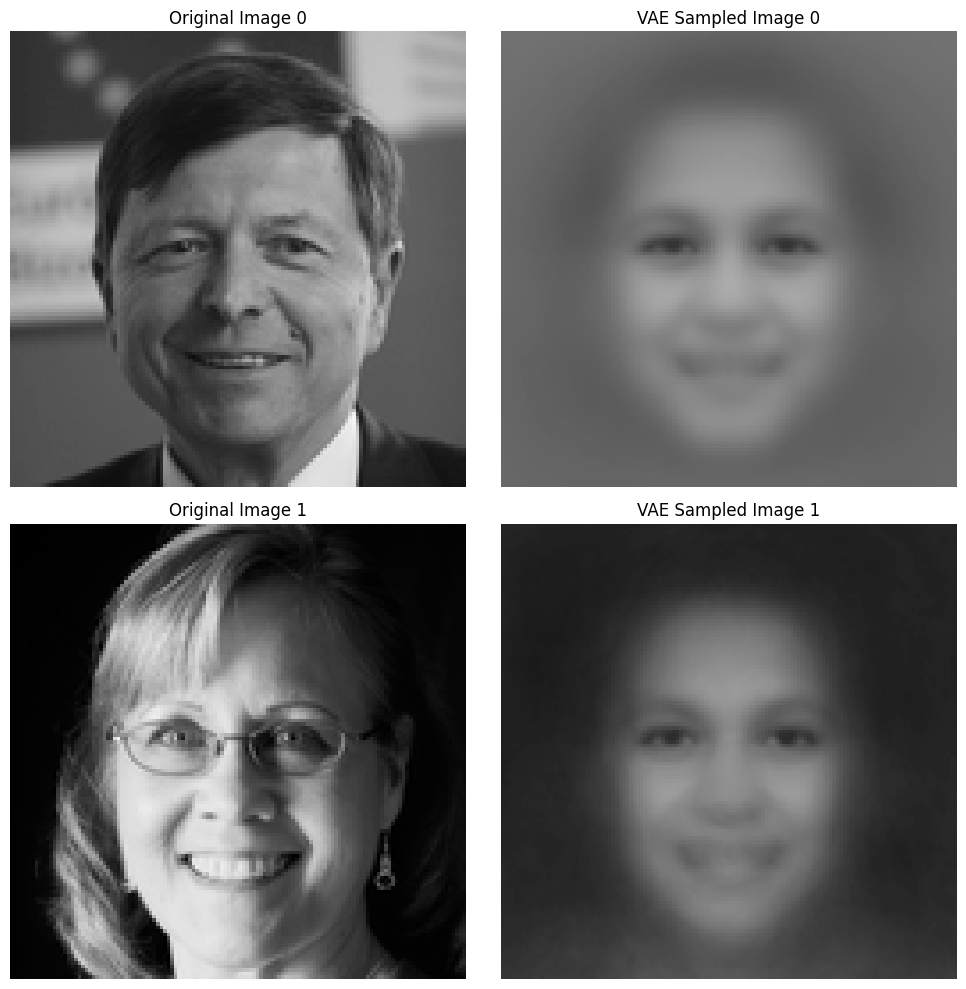

Loaded checkpoint from ./vae_best_{'lambda_l1': 1e-05, 'lambda_l2': 1e-05, 'use_l1': True, 'use_l2': True}.pth
Model Path: ./vae_best_{'lambda_l1': 1e-05, 'lambda_l2': 1e-05, 'use_l1': True, 'use_l2': True}.pth
Length of MSE list: 7000
Length of SSIM list: 7000
Length of PSNR list: 7000


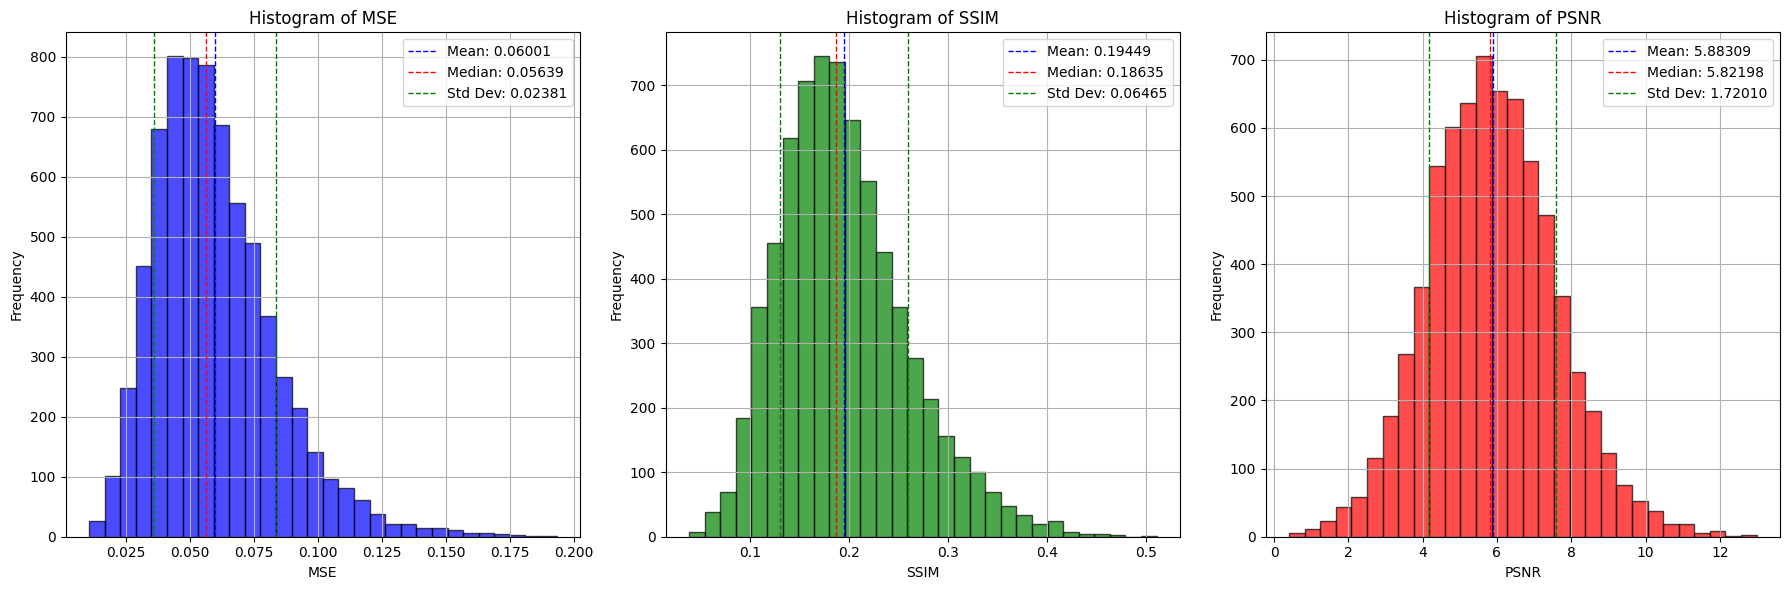

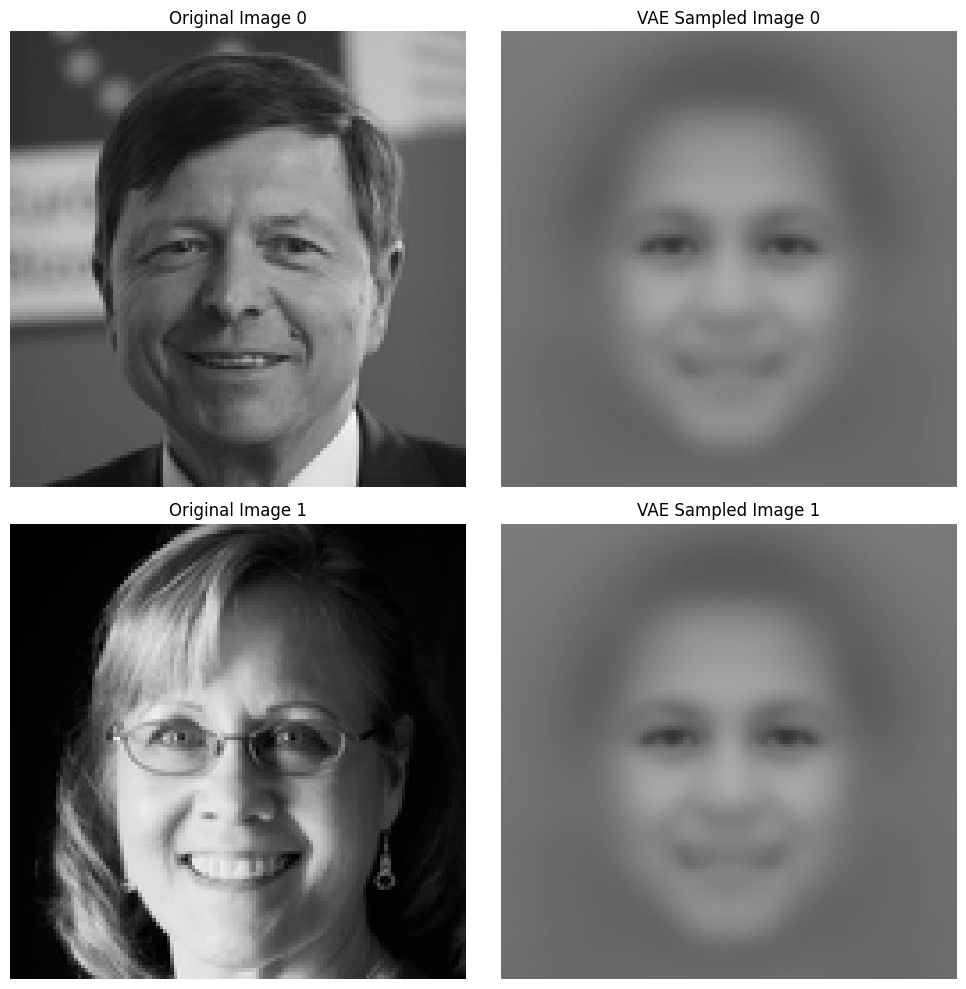

In [12]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of model paths to evaluate
model_paths = [
    "./vae_best_{'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False}.pth",
    "./vae_best_{'lambda_l1': 0.0, 'lambda_l2': 1e-05, 'use_l1': False, 'use_l2': True}.pth",
    "./vae_best_{'lambda_l1': 1e-05, 'lambda_l2': 0.0, 'use_l1': True, 'use_l2': False}.pth",
    "./vae_best_{'lambda_l1': 1e-05, 'lambda_l2': 1e-05, 'use_l1': True, 'use_l2': True}.pth",
]

# Function to plot histograms with mean, median, and std dev lines
def plot_histogram_with_stats(data, color, title, xlabel, ylabel):
    mean = np.mean(data)
    median = np.median(data)
    std = np.std(data)

    plt.hist(data, bins=30, color=color, edgecolor='black', alpha=0.7)
    plt.axvline(mean, color='blue', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.5f}')
    plt.axvline(median, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median:.5f}')
    plt.axvline(mean + std, color='green', linestyle='dashed', linewidth=1, label=f'Std Dev: {std:.5f}')
    plt.axvline(mean - std, color='green', linestyle='dashed', linewidth=1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)

# Function to plot original and VAE-compressed images
def plot_image_comparisons(original_imgs, vae_sample_imgs):
    plt.figure(figsize=(10, 10))
    
    num_images = len(original_imgs)
    
    for i in range(num_images):  
        # Plot original image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(original_imgs[i], cmap='gray', vmin=0, vmax=1)
        plt.title(f'Original Image {i}')
        plt.axis('off')
        
        # Plot VAE sampled image
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(vae_sample_imgs[i], cmap='gray', vmin=0, vmax=1)
        plt.title(f'VAE Sampled Image {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

for model_path in model_paths:
    # Initialize lists to store metrics and images for this model
    mse_list = []
    ssim_list = []
    psnr_list = []
    image_indices = []  # Store indices instead of image paths
    
    original_images_sample = []
    vae_samples_sample = []

    # Load the model
    vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
    vae.load_state_dict(torch.load(model_path))
    print("Loaded checkpoint from", model_path)
    
    vae.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            images, _ = batch
            images = images.to(device)  # Images should already be in shape (batch_size, channels, height, width)
            
            # Flatten the images to pass through the VAE
            images_flattened = images.view(images.size(0), -1)
            
            # Sample from the VAE
            vae_samples = vae(images_flattened)
            
            # Check if vae_samples is a tuple and extract the relevant tensor
            if isinstance(vae_samples, tuple):
                vae_samples = vae_samples[0]  # Adjust index based on VAE output format
            
            # Reshape VAE samples to match the original image dimensions
            vae_samples_reshaped = vae_samples.view(-1, 128, 128)  # Batch size x Height x Width

            # Convert images and VAE samples to numpy arrays
            original_images = images.cpu().numpy()  # Shape should be (batch_size, 1, 128, 128)
            vae_samples = vae_samples_reshaped.cpu().numpy()  # Shape should be (batch_size, 128, 128)

            for i in range(images.size(0)):  # Iterate over all images
                # Reshape images and samples
                original_img_float = (original_images[i].squeeze())  # Remove channel dimension, keep float
                vae_sample_img_float = (vae_samples[i])  # Keep float

                # Calculate MSE
                mse = mean_squared_error(original_img_float.flatten(), vae_sample_img_float.flatten())
                mse_list.append(mse)
                
                # Calculate SSIM
                ssim_value = ssim(original_img_float, vae_sample_img_float, data_range=vae_sample_img_float.max() - vae_sample_img_float.min())
                ssim_list.append(ssim_value)
                
                # Calculate PSNR
                psnr_value = psnr(original_img_float, vae_sample_img_float, data_range=vae_sample_img_float.max() - vae_sample_img_float.min())
                psnr_list.append(psnr_value)

                # Store images for plotting
                if len(original_images_sample) < 2:  # Store first 2 images for comparison plotting
                    original_images_sample.append(original_img_float)
                    vae_samples_sample.append(vae_sample_img_float)
        
    # Print lengths of lists for debugging
    print(f"Model Path: {model_path}")
    print(f"Length of MSE list: {len(mse_list)}")
    print(f"Length of SSIM list: {len(ssim_list)}")
    print(f"Length of PSNR list: {len(psnr_list)}")
    
    # Ensure all lists have the same length
    min_length = min(len(mse_list), len(ssim_list), len(psnr_list))
    mse_list = mse_list[:min_length]
    ssim_list = ssim_list[:min_length]
    psnr_list = psnr_list[:min_length]

    # Save metrics to CSV for this model
    reg_params_str = model_path.split('_')[2].replace('.pth', '')
    output_file = f'vae_evaluation_metrics_{reg_params_str}.csv'
    df = pd.DataFrame({
        'MSE': mse_list,
        'SSIM': ssim_list,
        'PSNR': psnr_list
    })
    df.to_csv(output_file, index=False)

    # Plot histograms for MSE, SSIM, and PSNR
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plot_histogram_with_stats(mse_list, 'blue', 'Histogram of MSE', 'MSE', 'Frequency')

    plt.subplot(1, 3, 2)
    plot_histogram_with_stats(ssim_list, 'green', 'Histogram of SSIM', 'SSIM', 'Frequency')

    plt.subplot(1, 3, 3)
    plot_histogram_with_stats(psnr_list, 'red', 'Histogram of PSNR', 'PSNR', 'Frequency')

    plt.tight_layout()
    plt.show()  # Display the plot

    # Plot original and VAE-sampled images for 2 examples
    plot_image_comparisons(original_images_sample, vae_samples_sample)


Print example of reconstruction

In [20]:
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error

def plot_single_image_reconstructions(image_index, model_paths, titles, test_loader, device, X_DIM, Z_DIM, HIDDEN_SIZE):
    # Get a batch of test images
    images, _ = next(iter(test_loader))  # Get a batch from the test loader
    images = images.to(device)  # Move to device
    
    # Select the image to be reconstructed
    original_img = images[image_index].cpu().numpy()

    # Initialize the plot
    fig, axes = plt.subplots(1, len(model_paths) + 1, figsize=(20, 5))
    
    # Plot the original image
    axes[0].imshow(original_img[0], cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Original Image')
    
    for i, (model_path, title) in enumerate(zip(model_paths, titles), start=1):
        # Load and evaluate the model
        vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
        vae.load_state_dict(torch.load(model_path))
        vae.eval()
        
        # Reconstruct the image
        with torch.no_grad():
            img_tensor = images[image_index].unsqueeze(0).to(device)
            img_flattened = img_tensor.view(img_tensor.size(0), -1)
            vae_samples = vae(img_flattened)
            
            # If vae_samples is a tuple, extract the relevant tensor
            if isinstance(vae_samples, tuple):
                vae_samples = vae_samples[0]
            
            vae_samples_reshaped = vae_samples.view(-1, 128, 128).cpu().numpy()[0]
        
        # Convert images and VAE samples to numpy arrays
        original_img_float = original_img[0]  # Remove channel dimension
        vae_sample_img_float = vae_samples_reshaped
        
        # Calculate MSE, SSIM, and PSNR
        mse_value = mean_squared_error(original_img_float.flatten(), vae_sample_img_float.flatten())
        psnr_value = psnr(original_img_float, vae_sample_img_float, data_range=vae_sample_img_float.max() - vae_sample_img_float.min())
        ssim_value = ssim(original_img_float, vae_sample_img_float, data_range=vae_sample_img_float.max() - vae_sample_img_float.min())
        
        # Plot reconstructed image
        axes[i].imshow(vae_sample_img_float, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(title)
        
        # Add MSE, PSNR, and SSIM text without additional gap
        axes[i].text(0.5, -0.03, 
                     f'MSE: {mse_value:.5f}\nPSNR: {psnr_value:.2f} dB\nSSIM: {ssim_value:.4f}', 
                     ha='center', va='top', transform=axes[i].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
    
    plt.tight_layout()
    plt.show()

import torch
from torch.utils.data import DataLoader

# Define your model paths and titles
model_paths = [
    "vae_best_{'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False}.pth",
    "vae_best_{'lambda_l1': 0.0, 'lambda_l2': 1e-05, 'use_l1': False, 'use_l2': True}.pth",
    "vae_best_{'lambda_l1': 1e-05, 'lambda_l2': 0.0, 'use_l1': True, 'use_l2': False}.pth",
    "vae_best_{'lambda_l1': 1e-05, 'lambda_l2': 1e-05, 'use_l1': True, 'use_l2': True}.pth"
]
titles = ["No Regularization", "L1 Regularization", "L2 Regularization" ,"L1 + L2 Regularization"]

# Choose an image index from the test loader
image_index = 2  # Change this index as needed

# Call the function
plot_single_image_reconstructions(
    image_index=image_index,
    model_paths=model_paths,
    titles=titles,
    test_loader=test_loader,
    device=device,
    X_DIM=X_DIM,
    Z_DIM=Z_DIM,
    HIDDEN_SIZE=HIDDEN_SIZE
)


NameError: name 'test_loader' is not defined

Loaded checkpoint from ./vae_best_{'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False}.pth
Loaded checkpoint from ./vae_best_{'lambda_l1': 0.0, 'lambda_l2': 1e-05, 'use_l1': False, 'use_l2': True}.pth


Loaded checkpoint from ./vae_best_{'lambda_l1': 1e-05, 'lambda_l2': 0.0, 'use_l1': True, 'use_l2': False}.pth
Loaded checkpoint from ./vae_best_{'lambda_l1': 1e-05, 'lambda_l2': 1e-05, 'use_l1': True, 'use_l2': True}.pth


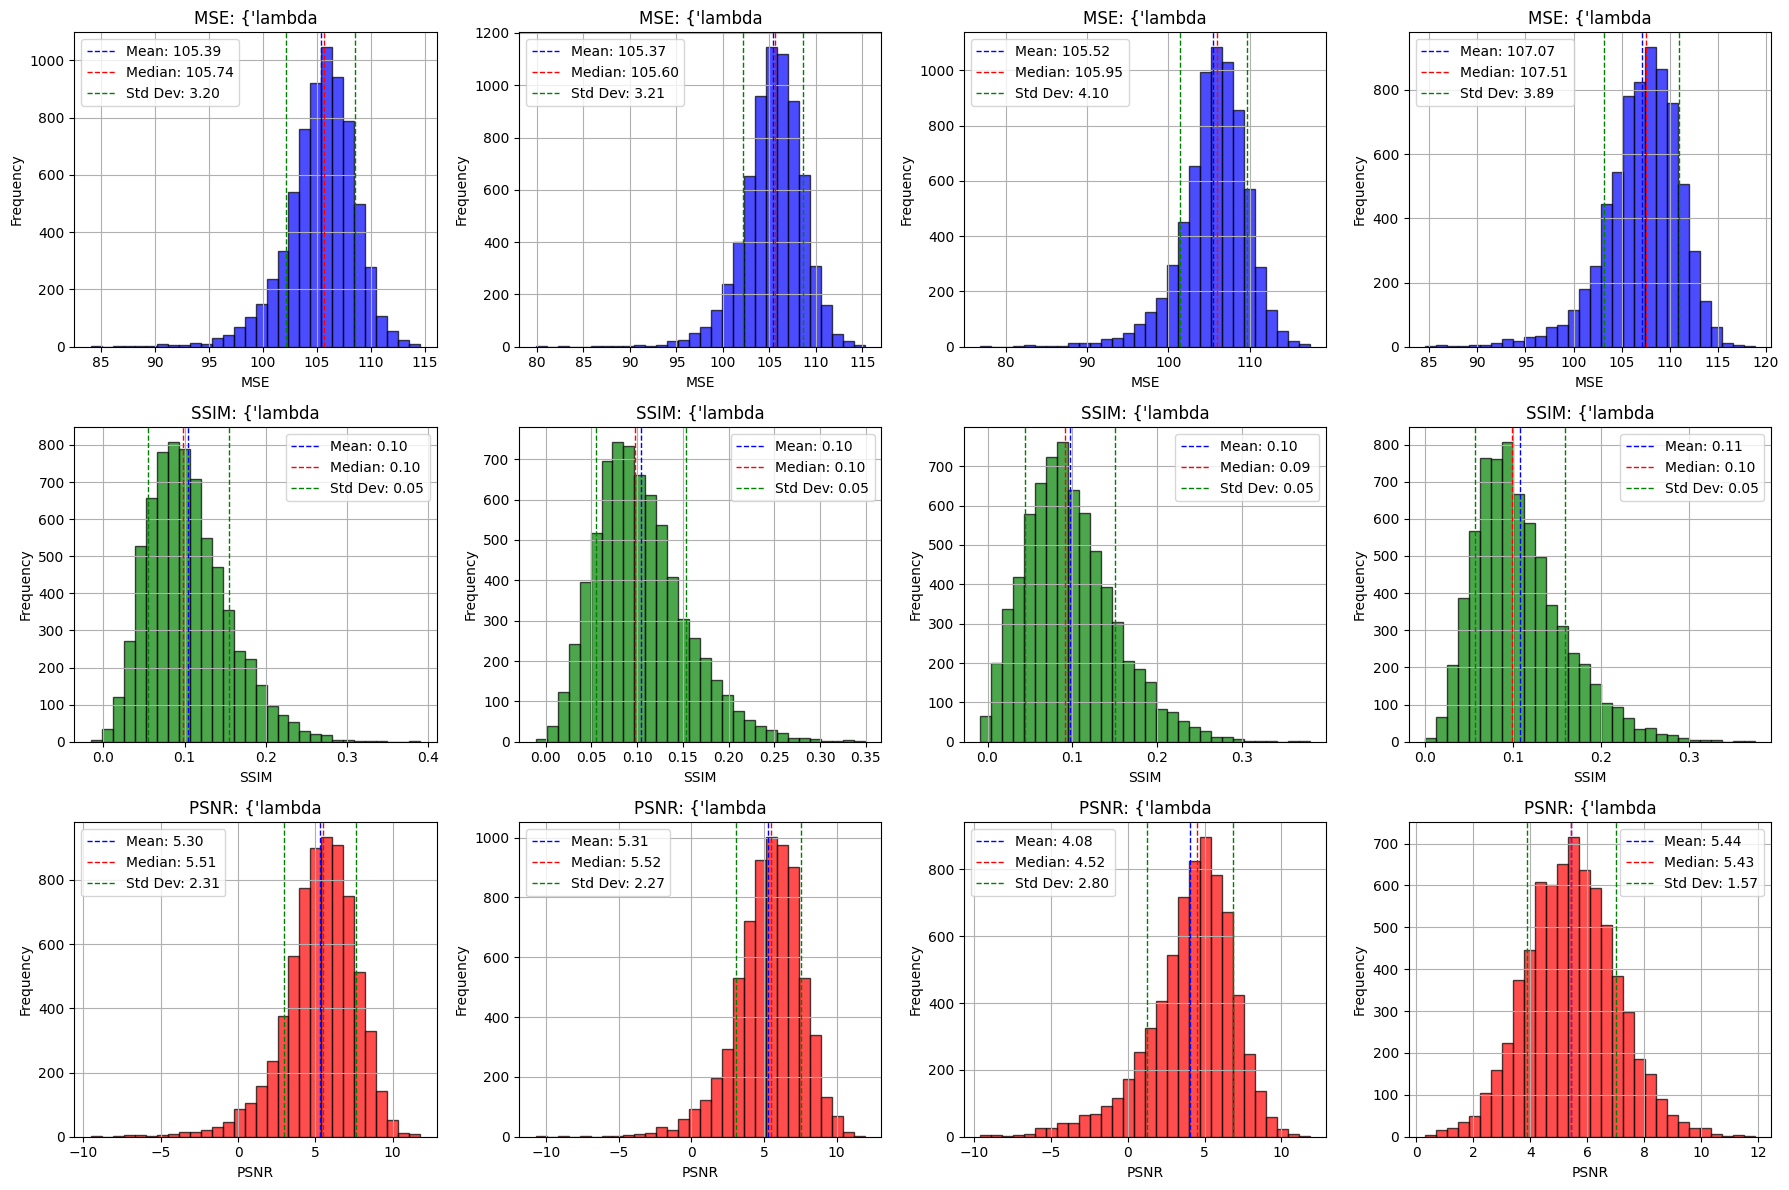

In [14]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import mean_squared_error

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of model paths to evaluate
model_paths = [
    "./vae_best_{'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False}.pth",
    "./vae_best_{'lambda_l1': 0.0, 'lambda_l2': 1e-05, 'use_l1': False, 'use_l2': True}.pth",
    "./vae_best_{'lambda_l1': 1e-05, 'lambda_l2': 0.0, 'use_l1': True, 'use_l2': False}.pth",
    "./vae_best_{'lambda_l1': 1e-05, 'lambda_l2': 1e-05, 'use_l1': True, 'use_l2': True}.pth",
]

# Initialize lists to store metrics across models
all_mse_lists = []
all_ssim_lists = []
all_psnr_lists = []
model_names = []

for model_path in model_paths:
    # Initialize lists to store metrics for this model
    mse_list = []
    ssim_list = []
    psnr_list = []
    image_indices = []  # Store indices instead of image paths

    # Load the model
    vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
    vae.load_state_dict(torch.load(model_path))
    print("Loaded checkpoint from", model_path)
    
    vae.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(test_loader):
            images = images.to(device)
            
            # Sample from the VAE
            vae_samples = vae.sample(num_samples=images.size(0)).view(images.size(0), 128, 128).data.cpu().numpy()
            
            # Convert images and VAE samples to numpy arrays
            original_images = images.cpu().numpy().squeeze()  # Remove channel dimension
            original_images = np.moveaxis(original_images, 1, -1)  # Move channel dimension to the end

            for i in range(images.size(0)):
                original_img = (original_images[i] * 255).astype(np.uint8)  # Convert to uint8
                vae_sample_img = (vae_samples[i] * 255).astype(np.uint8)  # Convert to uint8

                # Calculate MSE
                mse = mean_squared_error(original_img.flatten(), vae_sample_img.flatten())
                mse_list.append(mse)
                
                # Calculate SSIM
                ssim_value = ssim(original_img, vae_sample_img, data_range=vae_sample_img.max() - vae_sample_img.min())
                ssim_list.append(ssim_value)
                
                # Calculate PSNR
                psnr_value = psnr(original_img, vae_sample_img, data_range=vae_sample_img.max() - vae_sample_img.min())
                psnr_list.append(psnr_value)

                image_indices.append(batch_idx * test_loader.batch_size + i)  # Use index as identifier
        
    # Append lists to the overall lists
    all_mse_lists.append(mse_list)
    all_ssim_lists.append(ssim_list)
    all_psnr_lists.append(psnr_list)
    model_names.append(model_path.split('_')[2].replace('.pth', ''))

    # Save metrics to CSV for this model
    reg_params_str = model_path.split('_')[2].replace('.pth', '')
    output_file = f'vae_evaluation_metrics_{reg_params_str}.csv'
    df = pd.DataFrame({
        'Image Index': image_indices,  # Updated column name
        'MSE': mse_list,
        'SSIM': ssim_list,
        'PSNR': psnr_list
    })
    df.to_csv(output_file, index=False)

# Plot metrics
plt.figure(figsize=(18, 12))

# Function to plot histogram with mean, median, and std
def plot_histogram_with_stats(data, color, title, xlabel, ylabel):
    mean = np.mean(data)
    median = np.median(data)
    std = np.std(data)

    plt.hist(data, bins=30, color=color, edgecolor='black', alpha=0.7)
    plt.axvline(mean, color='blue', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')
    plt.axvline(mean + std, color='green', linestyle='dashed', linewidth=1, label=f'Std Dev: {std:.2f}')
    plt.axvline(mean - std, color='green', linestyle='dashed', linewidth=1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)

# Plot MSE histograms in the first row
for idx, mse_list in enumerate(all_mse_lists):
    plt.subplot(3, len(model_paths), idx + 1)
    plot_histogram_with_stats(mse_list, 'blue', f'MSE: {model_names[idx]}', 'MSE', 'Frequency')

# Plot SSIM histograms in the second row
for idx, ssim_list in enumerate(all_ssim_lists):
    plt.subplot(3, len(model_paths), idx + 1 + len(model_paths))
    plot_histogram_with_stats(ssim_list, 'green', f'SSIM: {model_names[idx]}', 'SSIM', 'Frequency')

# Plot PSNR histograms in the third row
for idx, psnr_list in enumerate(all_psnr_lists):
    plt.subplot(3, len(model_paths), idx + 1 + 2 * len(model_paths))
    plot_histogram_with_stats(psnr_list, 'red', f'PSNR: {model_names[idx]}', 'PSNR', 'Frequency')

plt.tight_layout()
plt.show()  # Display the plot


In [15]:
# Function to add Gaussian noise to data
def add_gaussian_noise(data, mean=0.0, std=0.1):
    noise = torch.normal(mean, std, data.shape).to(device)
    noisy_data = data + noise
    return noisy_data

# Adding Gaussian noise to the datasets
data_tensor_noisy = add_gaussian_noise(data_tensor)

del train_loader, val_loader, test_loader
del train_dataset, val_dataset, test_dataset

# Create TensorDataset from noisy data
train_dataset_noisy = TensorDataset(data_tensor_noisy[train_indices], data_tensor_noisy[train_indices])
val_dataset_noisy = TensorDataset(data_tensor_noisy[val_indices], data_tensor_noisy[val_indices])
test_dataset_noisy = TensorDataset(data_tensor_noisy[test_indices], data_tensor_noisy[test_indices])

# Create data loaders for noisy datasets
train_loader_noisy = DataLoader(train_dataset_noisy, batch_size=128, shuffle=True)
val_loader_noisy = DataLoader(val_dataset_noisy, batch_size=128, shuffle=False)
test_loader_noisy = DataLoader(test_dataset_noisy, batch_size=128, shuffle=False)

# Print the sizes of each noisy dataset
print(f"Noisy Training set size: {len(train_dataset_noisy)}")
print(f"Noisy Validation set size: {len(val_dataset_noisy)}")
print(f"Noisy Test set size: {len(test_dataset_noisy)}")


Noisy Training set size: 49000
Noisy Validation set size: 14000
Noisy Test set size: 7000


Training set images:


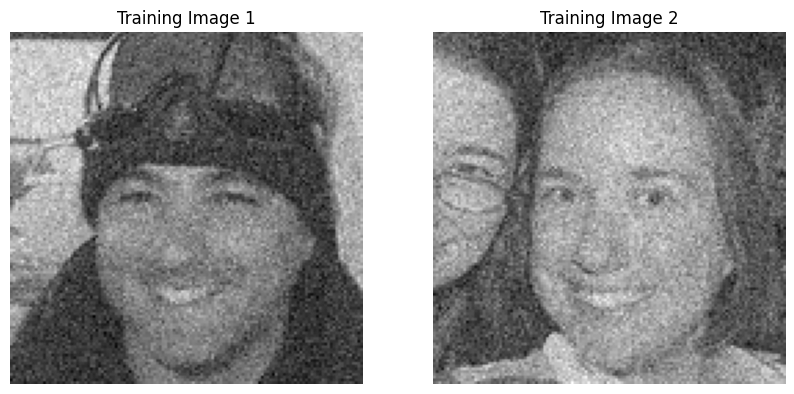

Validation set images:


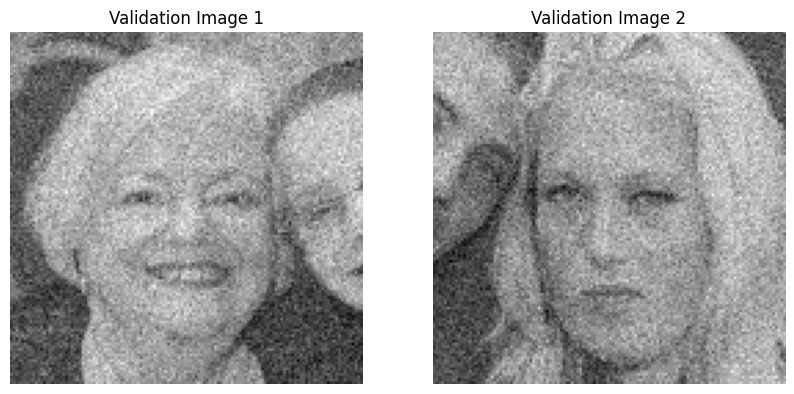

Test set images:


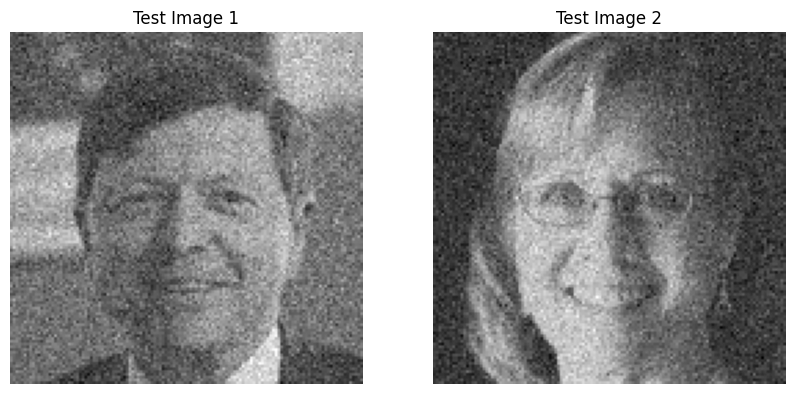

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images in grayscale
def show_images(images, title):
    plt.figure(figsize=(10, 5))
    num_images = min(len(images), 2)  # Display up to two images
    for i in range(num_images):
        plt.subplot(1, 2, i + 1)
        img = images[i].cpu().numpy().squeeze()  # Remove channel dimension if it exists
        plt.imshow(img, cmap='gray')  # Display in grayscale
        plt.title(f'{title} Image {i + 1}')
        plt.axis('off')
    plt.show()

# Fetch and display images from each data loader
def display_images_from_loader(loader, title):
    data_iter = iter(loader)
    images, _ = next(data_iter)
    show_images(images, title)

# Display images from each data loader
print("Training set images:")
display_images_from_loader(train_loader_noisy, 'Training')

print("Validation set images:")
display_images_from_loader(val_loader_noisy, 'Validation')

print("Test set images:")
display_images_from_loader(test_loader_noisy, 'Test')


Epoch: 0 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 1172.27915 | Validation Loss: 1153.01765 | Time: 1.110 sec
Epoch: 1 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 1157.69961 | Validation Loss: 1150.75597 | Time: 1.109 sec
Epoch: 2 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 1156.45132 | Validation Loss: 1149.72408 | Time: 1.111 sec
Epoch: 3 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 1155.51429 | Validation Loss: 1149.46706 | Time: 1.113 sec
Epoch: 4 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 1154.46043 | Validation Loss: 1147.94200 | Time: 1.109 sec
Epoch: 5 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 1154.00500 | Va

Epoch: 8 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 1152.74005 | Validation Loss: 1146.92717 | Time: 1.113 sec
Epoch: 9 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 1152.36191 | Validation Loss: 1145.65785 | Time: 1.113 sec
Epoch: 10 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 1152.04492 | Validation Loss: 1146.42219 | Time: 1.112 sec
Epoch: 11 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 1151.99406 | Validation Loss: 1145.80841 | Time: 1.113 sec
Epoch: 12 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 1151.99587 | Validation Loss: 1145.74453 | Time: 1.112 sec
Epoch: 13 | Regularization: {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False} | Training Loss: 1151.44517 

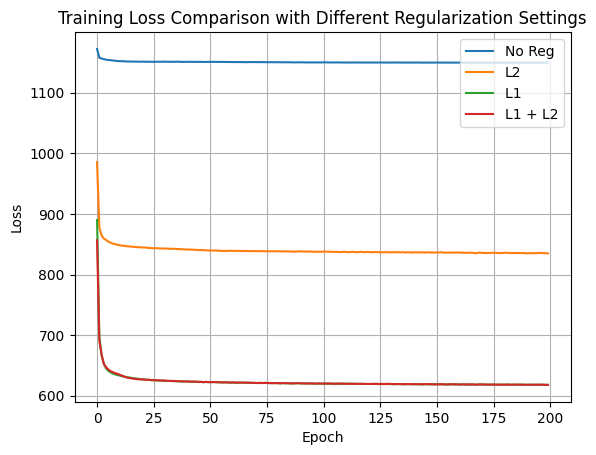

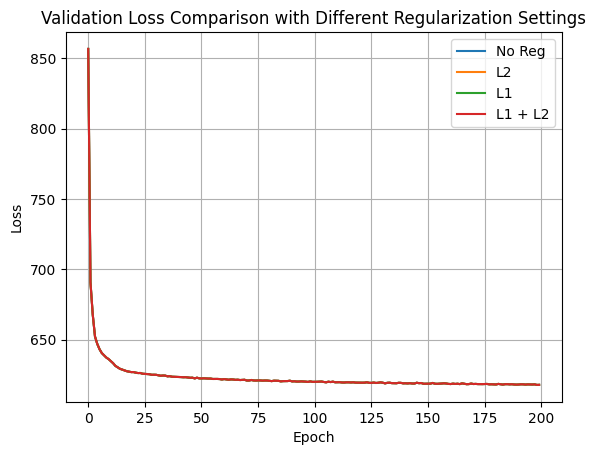

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from torch.utils.data import DataLoader

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize variables for tracking loss
regularization_settings = [
    {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False},
    {'lambda_l1': 0.0, 'lambda_l2': 1e-5, 'use_l1': False, 'use_l2': True},
    {'lambda_l1': 1e-5, 'lambda_l2': 0.0, 'use_l1': True, 'use_l2': False},
    {'lambda_l1': 1e-5, 'lambda_l2': 1e-5, 'use_l1': True, 'use_l2': True},
]

# Create lists to store training and validation losses for each regularization setting
all_train_losses = {}
all_val_losses = {}
best_val_loss = {}
best_model_state = {}

# Loop through each regularization setting
for reg_settings in regularization_settings:
    # Create model and optimizer
    vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
    vae_optim = torch.optim.Adam(params=vae.parameters(), lr=LEARNING_RATE)
    vae.train()
    
    # Generate label for this setting
    label = f"$\\lambda_{{L1}} = {reg_settings['lambda_l1']}, \\lambda_{{L2}} = {reg_settings['lambda_l2']}$"

    # Store losses for this setting
    train_losses = []
    val_losses = []
    
    # Initialize best validation loss as infinity
    best_val_loss[label] = float('inf')

    # Training loop
    for epoch in range(NUM_EPOCHS):
        epoch_start_time = time.time()
        batch_train_losses = []
        batch_val_losses = []

        # Training
        for batch in train_loader_noisy:
            x = batch[0].to(device).view(-1, X_DIM)  # just the images
            x_recon, mu, logvar, z = vae(x)
            # Calculate the loss with current regularization settings
            loss = loss_function(x_recon, x, mu, logvar, model=vae,
                                 lambda_l1=reg_settings['lambda_l1'],
                                 lambda_l2=reg_settings['lambda_l2'],
                                 use_l1=reg_settings['use_l1'],
                                 use_l2=reg_settings['use_l2'])
            # Optimization
            vae_optim.zero_grad()
            loss.backward()
            vae_optim.step()
            batch_train_losses.append(loss.data.cpu().item())

        # Validation
        vae.eval()
        with torch.no_grad():
            for batch in val_loader_noisy:
                x = batch[0].to(device).view(-1, X_DIM)
                x_recon, mu, logvar, z = vae(x)
                val_loss = loss_function(x_recon, x, mu, logvar, model=vae,
                                         lambda_l1=reg_settings['lambda_l1'],
                                         lambda_l2=reg_settings['lambda_l2'],
                                         use_l1=reg_settings['use_l1'],
                                         use_l2=reg_settings['use_l2'])
                batch_val_losses.append(val_loss.data.cpu().item())

        train_losses.append(np.mean(batch_train_losses))
        val_losses.append(np.mean(batch_val_losses))

        # Check if current validation loss is the best we've seen
        if val_losses[-1] < best_val_loss[label]:
            best_val_loss[label] = val_losses[-1]
            best_model_state[label] = vae.state_dict()

        print("Epoch: {} | Regularization: {} | Training Loss: {:.5f} | Validation Loss: {:.5f} | Time: {:.3f} sec".format(
            epoch, reg_settings, train_losses[-1], val_losses[-1], time.time() - epoch_start_time
        ))
    
    # Store losses for this regularization setting
    all_train_losses[label] = train_losses
    all_val_losses[label] = val_losses

    # Save the best model for this regularization setting
    best_model_path = f"./vae_best_noisy_{str(reg_settings)}.pth"
    torch.save(best_model_state[label], best_model_path)
    print(f"Best model for {label} saved at {best_model_path} with val loss {best_val_loss[label]:.4f}")

# Plot training losses with custom legend labels
for label, train_losses in all_train_losses.items():
    if label == r"$\lambda_{L1} = 0.0, \lambda_{L2} = 0.0$":
        plt.plot(train_losses, label='No Reg')
    elif label == r"$\lambda_{L1} = 0.0, \lambda_{L2} = 1e-05$":
        plt.plot(train_losses, label='L2')
    elif label == r"$\lambda_{L1} = 1e-05, \lambda_{L2} = 0.0$":
        plt.plot(train_losses, label='L1 ')
    elif label == r"$\lambda_{L1} = 1e-05, \lambda_{L2} = 1e-05$":
        plt.plot(train_losses, label='L1 + L2')

# Add title and labels for training losses
plt.title('Training Loss Comparison with Different Regularization Settings')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot validation losses with custom legend labels

for label, val_losses in all_val_losses.items():
    if label == r"$\lambda_{L1} = 0.0, \lambda_{L2} = 0.0$":
        plt.plot(val_losses, label='No Reg')
    elif label == r"$\lambda_{L1} = 0.0, \lambda_{L2} = 1e-05$":
        plt.plot(val_losses, label='L2')
    elif label == r"$\lambda_{L1} = 1e-05, \lambda_{L2} = 0.0$":
        plt.plot(val_losses, label='L1 ')
    elif label == r"$\lambda_{L1} = 1e-05, \lambda_{L2} = 1e-05$":
        plt.plot(val_losses, label='L1 + L2')

# Add title and labels for validation losses
plt.title('Validation Loss Comparison with Different Regularization Settings')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

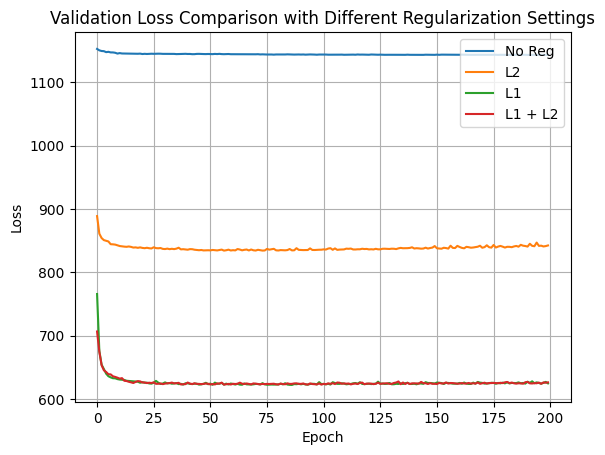

In [21]:

for label, val_losses in all_val_losses.items():
    if label == r"$\lambda_{L1} = 0.0, \lambda_{L2} = 0.0$":
        plt.plot(val_losses, label='No Reg')
    elif label == r"$\lambda_{L1} = 0.0, \lambda_{L2} = 1e-05$":
        plt.plot(val_losses, label='L2')
    elif label == r"$\lambda_{L1} = 1e-05, \lambda_{L2} = 0.0$":
        plt.plot(val_losses, label='L1 ')
    elif label == r"$\lambda_{L1} = 1e-05, \lambda_{L2} = 1e-05$":
        plt.plot(val_losses, label='L1 + L2')

# Add title and labels for validation losses
plt.title('Validation Loss Comparison with Different Regularization Settings')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

Loaded checkpoint from ./vae_best_noisy_{'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False}.pth


Model Path: ./vae_best_noisy_{'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False}.pth
Length of MSE list: 7000
Length of SSIM list: 7000
Length of PSNR list: 7000


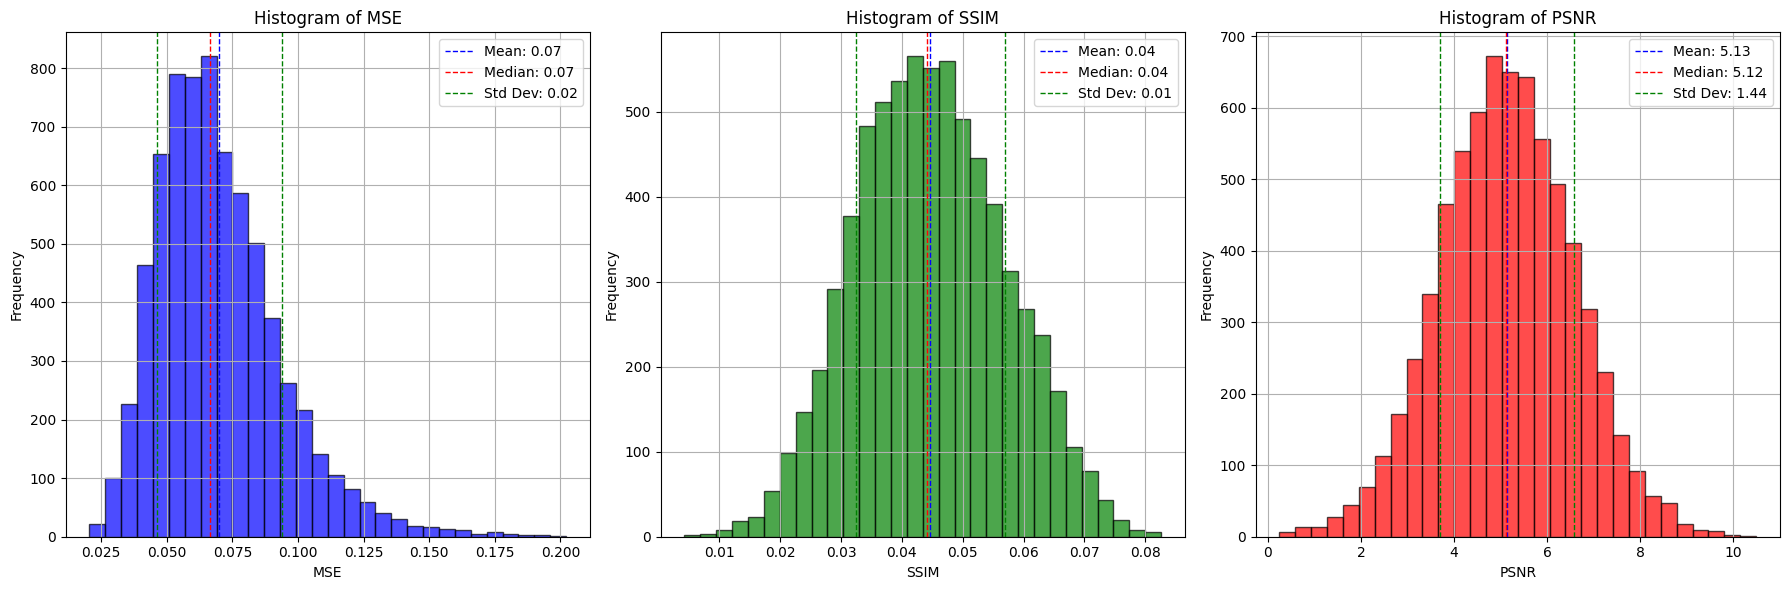

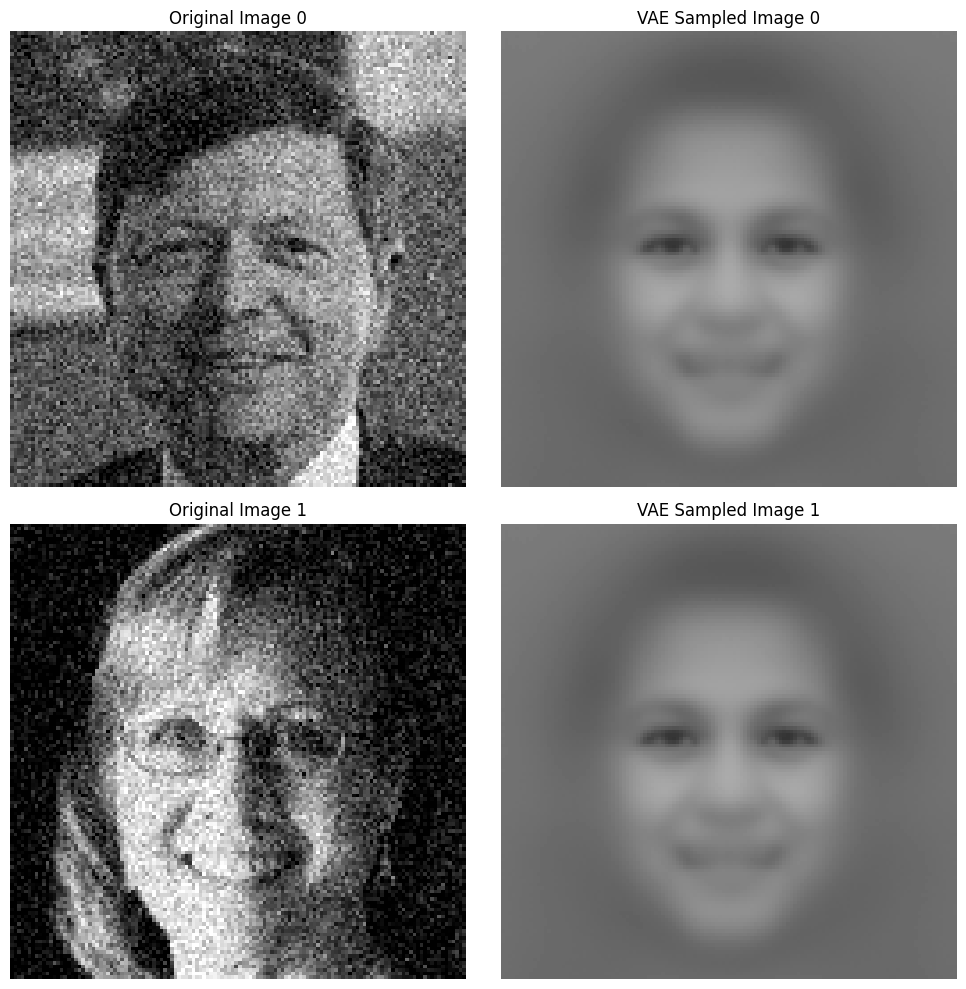

Loaded checkpoint from ./vae_best_noisy_{'lambda_l1': 0.0, 'lambda_l2': 1e-05, 'use_l1': False, 'use_l2': True}.pth
Model Path: ./vae_best_noisy_{'lambda_l1': 0.0, 'lambda_l2': 1e-05, 'use_l1': False, 'use_l2': True}.pth
Length of MSE list: 7000
Length of SSIM list: 7000
Length of PSNR list: 7000


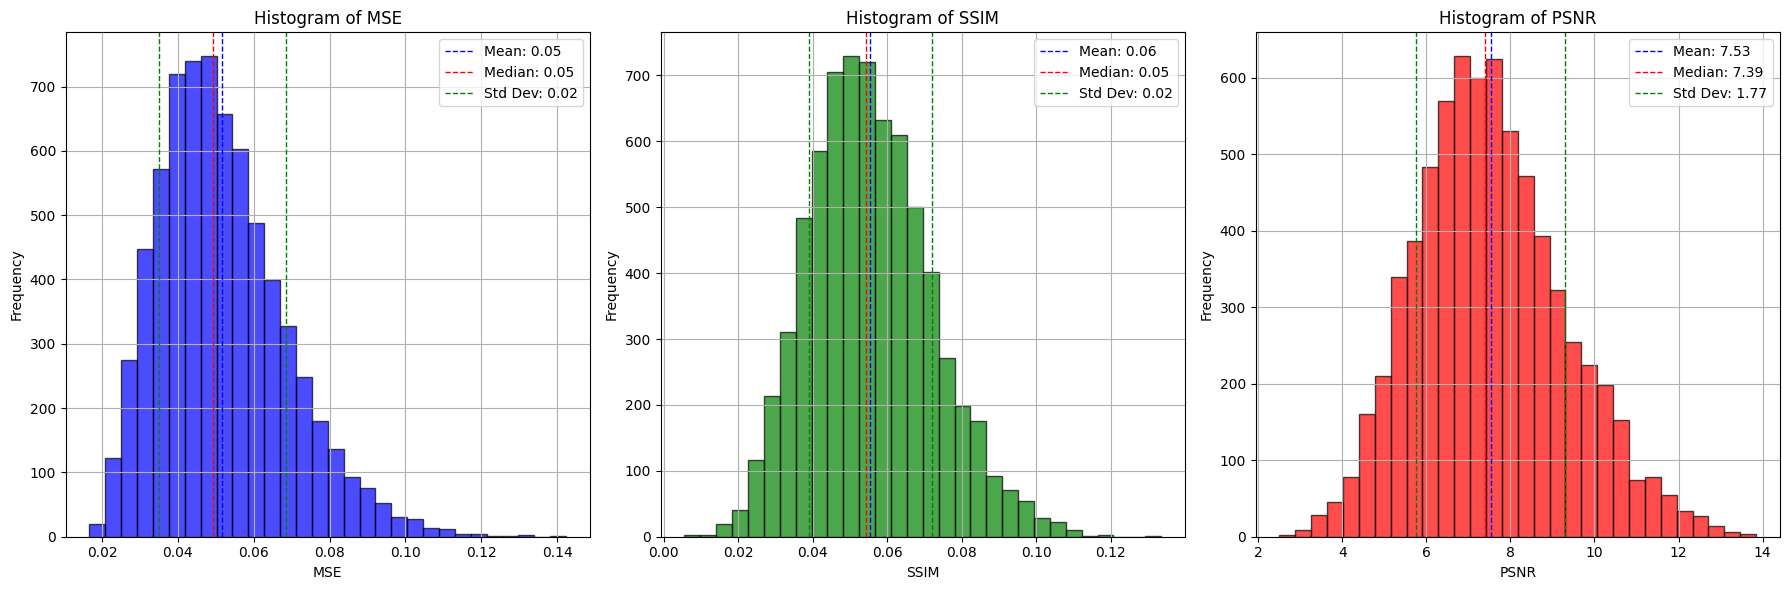

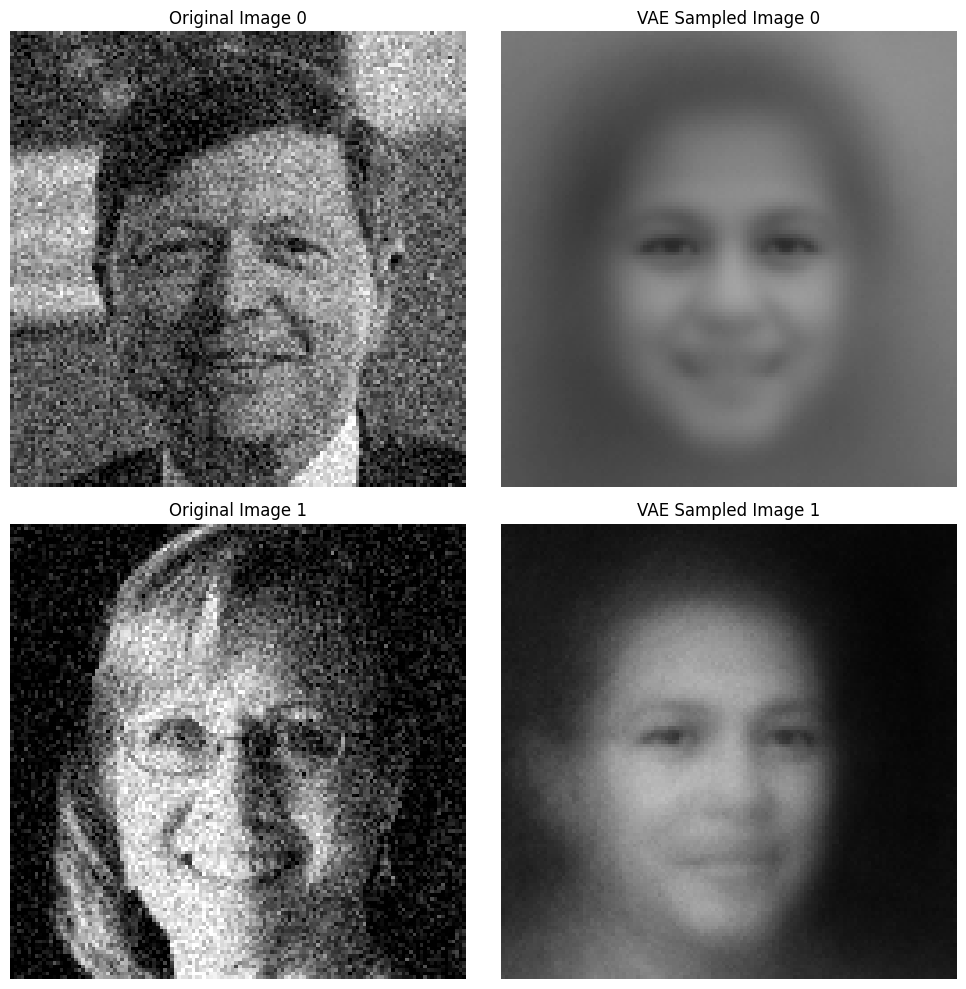

Loaded checkpoint from ./vae_best_noisy_{'lambda_l1': 1e-05, 'lambda_l2': 0.0, 'use_l1': True, 'use_l2': False}.pth
Model Path: ./vae_best_noisy_{'lambda_l1': 1e-05, 'lambda_l2': 0.0, 'use_l1': True, 'use_l2': False}.pth
Length of MSE list: 7000
Length of SSIM list: 7000
Length of PSNR list: 7000


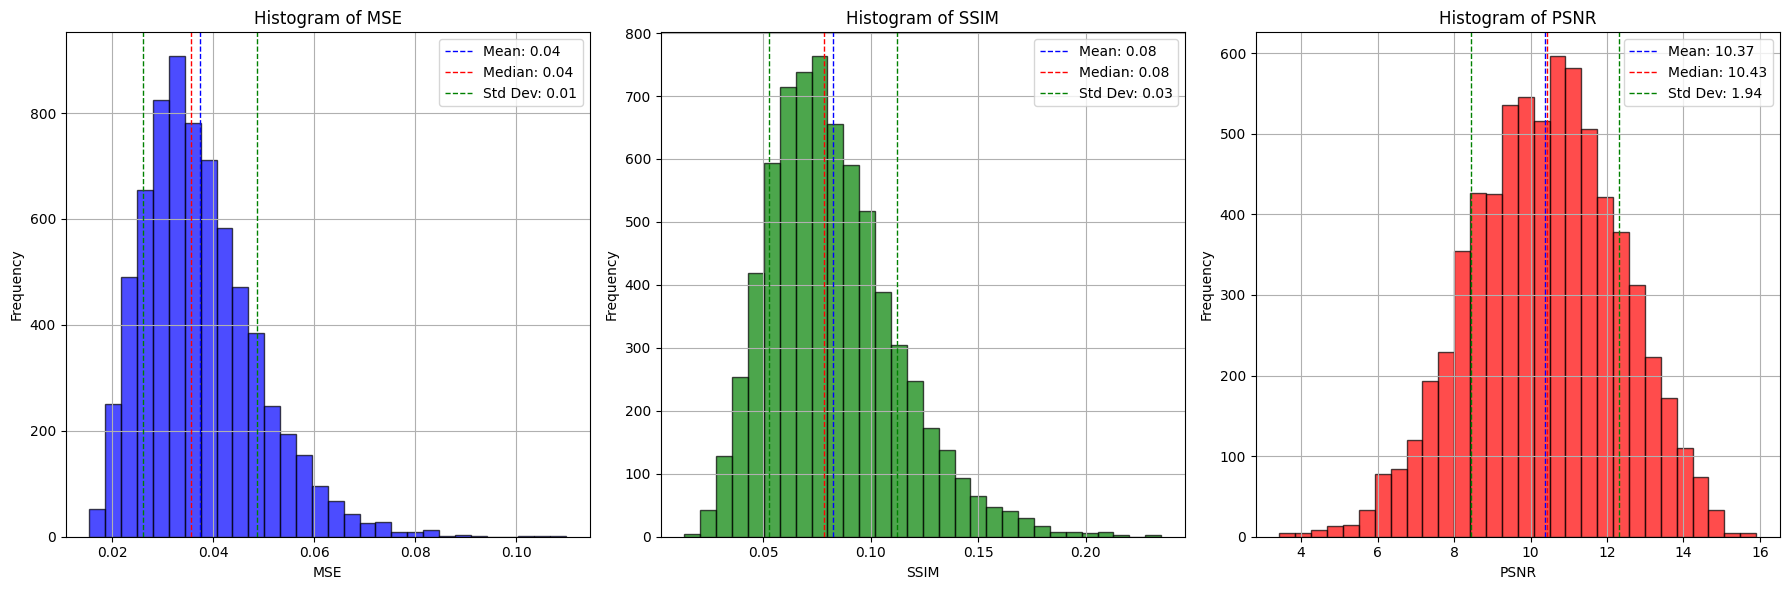

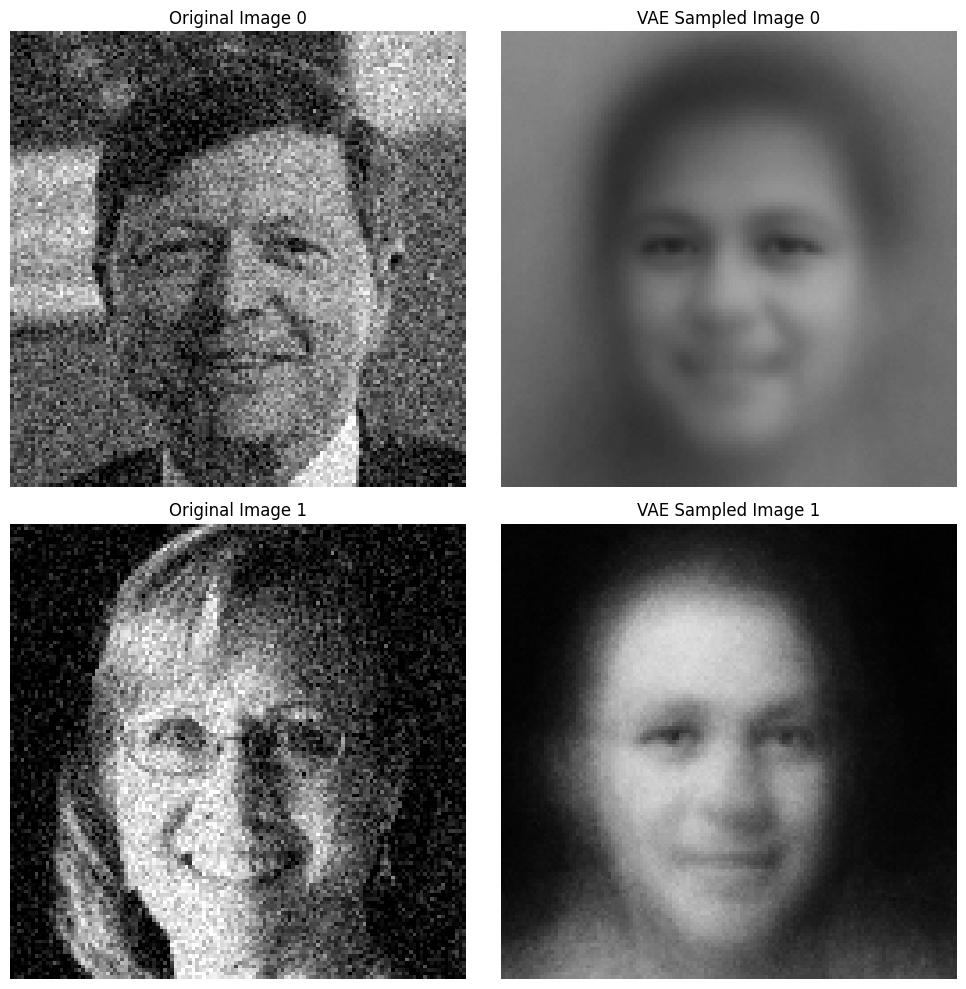

Loaded checkpoint from ./vae_best_noisy_{'lambda_l1': 1e-05, 'lambda_l2': 1e-05, 'use_l1': True, 'use_l2': True}.pth
Model Path: ./vae_best_noisy_{'lambda_l1': 1e-05, 'lambda_l2': 1e-05, 'use_l1': True, 'use_l2': True}.pth
Length of MSE list: 7000
Length of SSIM list: 7000
Length of PSNR list: 7000


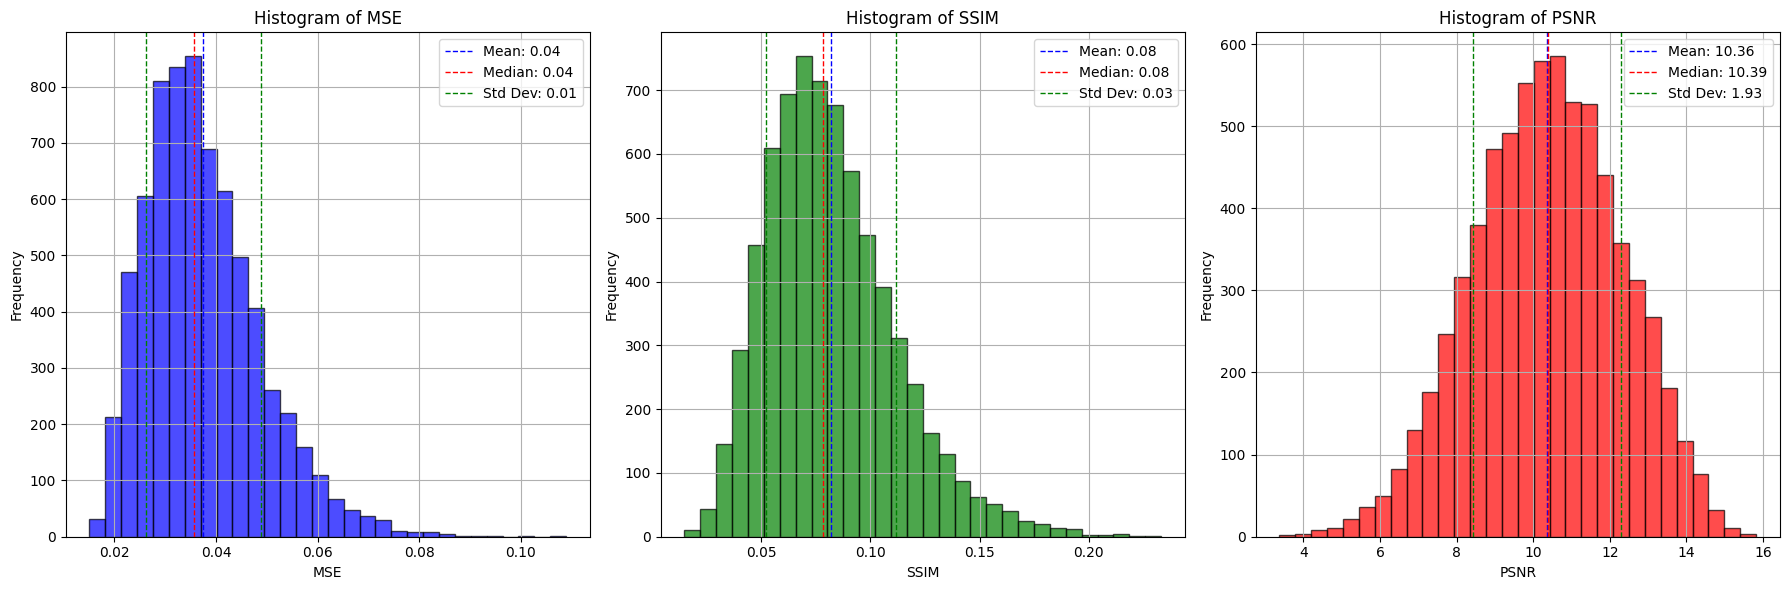

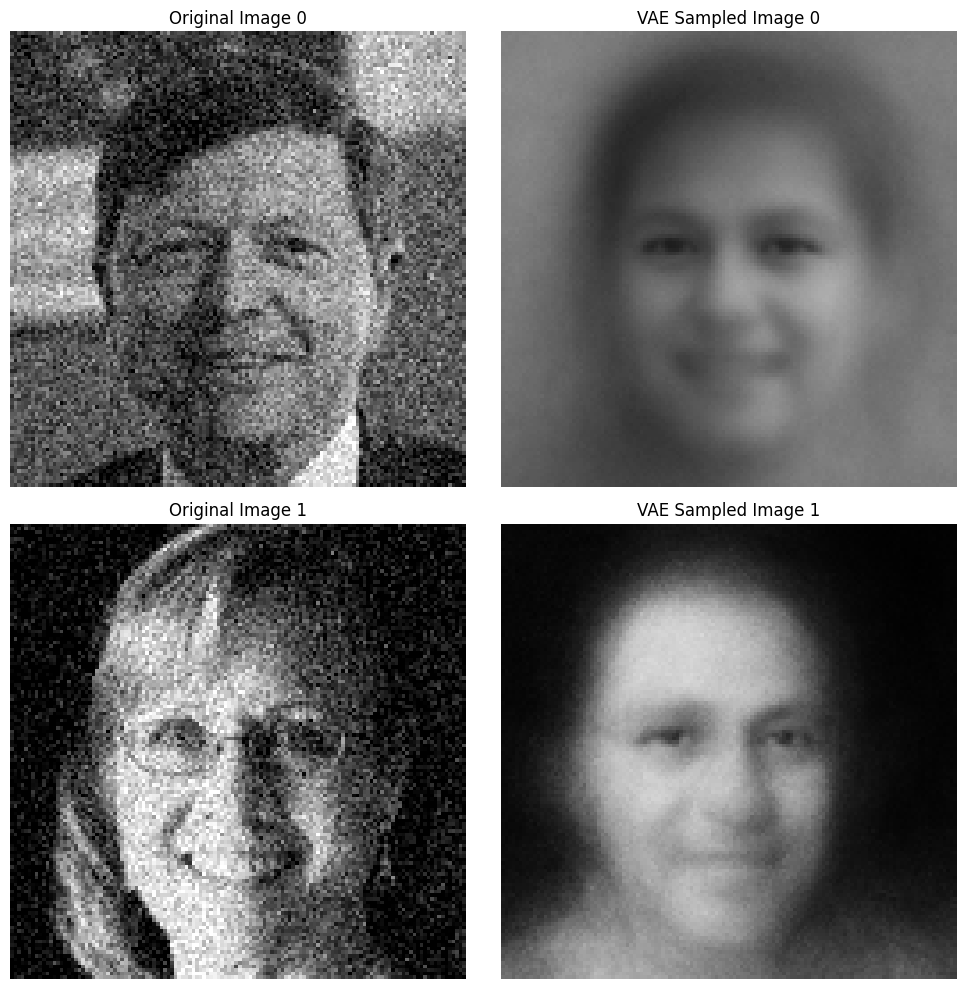

In [18]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of model paths to evaluate
model_paths = [
    "./vae_best_noisy_{'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False}.pth",
    "./vae_best_noisy_{'lambda_l1': 0.0, 'lambda_l2': 1e-05, 'use_l1': False, 'use_l2': True}.pth",
    "./vae_best_noisy_{'lambda_l1': 1e-05, 'lambda_l2': 0.0, 'use_l1': True, 'use_l2': False}.pth",
    "./vae_best_noisy_{'lambda_l1': 1e-05, 'lambda_l2': 1e-05, 'use_l1': True, 'use_l2': True}.pth",
]

# Function to plot histograms with mean, median, and std dev lines
def plot_histogram_with_stats(data, color, title, xlabel, ylabel):
    mean = np.mean(data)
    median = np.median(data)
    std = np.std(data)

    plt.hist(data, bins=30, color=color, edgecolor='black', alpha=0.7)
    plt.axvline(mean, color='blue', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')
    plt.axvline(mean + std, color='green', linestyle='dashed', linewidth=1, label=f'Std Dev: {std:.2f}')
    plt.axvline(mean - std, color='green', linestyle='dashed', linewidth=1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)

# Function to plot original and VAE-compressed images
def plot_image_comparisons(original_imgs, vae_sample_imgs):
    plt.figure(figsize=(10, 10))
    
    num_images = len(original_imgs)
    
    for i in range(num_images):  
        # Plot original image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(original_imgs[i], cmap='gray', vmin=0, vmax=1)
        plt.title(f'Original Image {i}')
        plt.axis('off')
        
        # Plot VAE sampled image
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(vae_sample_imgs[i], cmap='gray', vmin=0, vmax=1)
        plt.title(f'VAE Sampled Image {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

for model_path in model_paths:
    # Initialize lists to store metrics and images for this model
    mse_list = []
    ssim_list = []
    psnr_list = []
    image_indices = []  # Store indices instead of image paths
    
    original_images_sample = []
    vae_samples_sample = []

    # Load the model
    vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
    vae.load_state_dict(torch.load(model_path))
    print("Loaded checkpoint from", model_path)
    
    vae.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader_noisy):
            images, _ = batch
            images = images.to(device)  # Images should already be in shape (batch_size, channels, height, width)
            
            # Flatten the images to pass through the VAE
            images_flattened = images.view(images.size(0), -1)
            
            # Sample from the VAE
            vae_samples = vae(images_flattened)
            
            # Check if vae_samples is a tuple and extract the relevant tensor
            if isinstance(vae_samples, tuple):
                vae_samples = vae_samples[0]  # Adjust index based on VAE output format
            
            # Reshape VAE samples to match the original image dimensions
            vae_samples_reshaped = vae_samples.view(-1, 128, 128)  # Batch size x Height x Width

            # Convert images and VAE samples to numpy arrays
            original_images = images.cpu().numpy()  # Shape should be (batch_size, 1, 128, 128)
            vae_samples = vae_samples_reshaped.cpu().numpy()  # Shape should be (batch_size, 128, 128)

            for i in range(images.size(0)):  # Iterate over all images
                # Reshape images and samples
                original_img_float = (original_images[i].squeeze())  # Remove channel dimension, keep float
                vae_sample_img_float = (vae_samples[i])  # Keep float

                # Calculate MSE
                mse = mean_squared_error(original_img_float.flatten(), vae_sample_img_float.flatten())
                mse_list.append(mse)
                
                # Calculate SSIM
                ssim_value = ssim(original_img_float, vae_sample_img_float, data_range=vae_sample_img_float.max() - vae_sample_img_float.min())
                ssim_list.append(ssim_value)
                
                # Calculate PSNR
                psnr_value = psnr(original_img_float, vae_sample_img_float, data_range=vae_sample_img_float.max() - vae_sample_img_float.min())
                psnr_list.append(psnr_value)

                # Store images for plotting
                if len(original_images_sample) < 2:  # Store first 2 images for comparison plotting
                    original_images_sample.append(original_img_float)
                    vae_samples_sample.append(vae_sample_img_float)
        
    # Print lengths of lists for debugging
    print(f"Model Path: {model_path}")
    print(f"Length of MSE list: {len(mse_list)}")
    print(f"Length of SSIM list: {len(ssim_list)}")
    print(f"Length of PSNR list: {len(psnr_list)}")
    
    # Ensure all lists have the same length
    min_length = min(len(mse_list), len(ssim_list), len(psnr_list))
    mse_list = mse_list[:min_length]
    ssim_list = ssim_list[:min_length]
    psnr_list = psnr_list[:min_length]

    # Save metrics to CSV for this model
    reg_params_str = model_path.split('_')[2].replace('.pth', '')
    output_file = f'vae_evaluation_metrics_{reg_params_str}.csv'
    df = pd.DataFrame({
        'MSE': mse_list,
        'SSIM': ssim_list,
        'PSNR': psnr_list
    })
    df.to_csv(output_file, index=False)

    # Plot histograms for MSE, SSIM, and PSNR
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plot_histogram_with_stats(mse_list, 'blue', 'Histogram of MSE', 'MSE', 'Frequency')

    plt.subplot(1, 3, 2)
    plot_histogram_with_stats(ssim_list, 'green', 'Histogram of SSIM', 'SSIM', 'Frequency')

    plt.subplot(1, 3, 3)
    plot_histogram_with_stats(psnr_list, 'red', 'Histogram of PSNR', 'PSNR', 'Frequency')

    plt.tight_layout()
    plt.show()  # Display the plot

    # Plot original and VAE-sampled images for 2 examples
    plot_image_comparisons(original_images_sample, vae_samples_sample)


Print example of compression for different regularizations

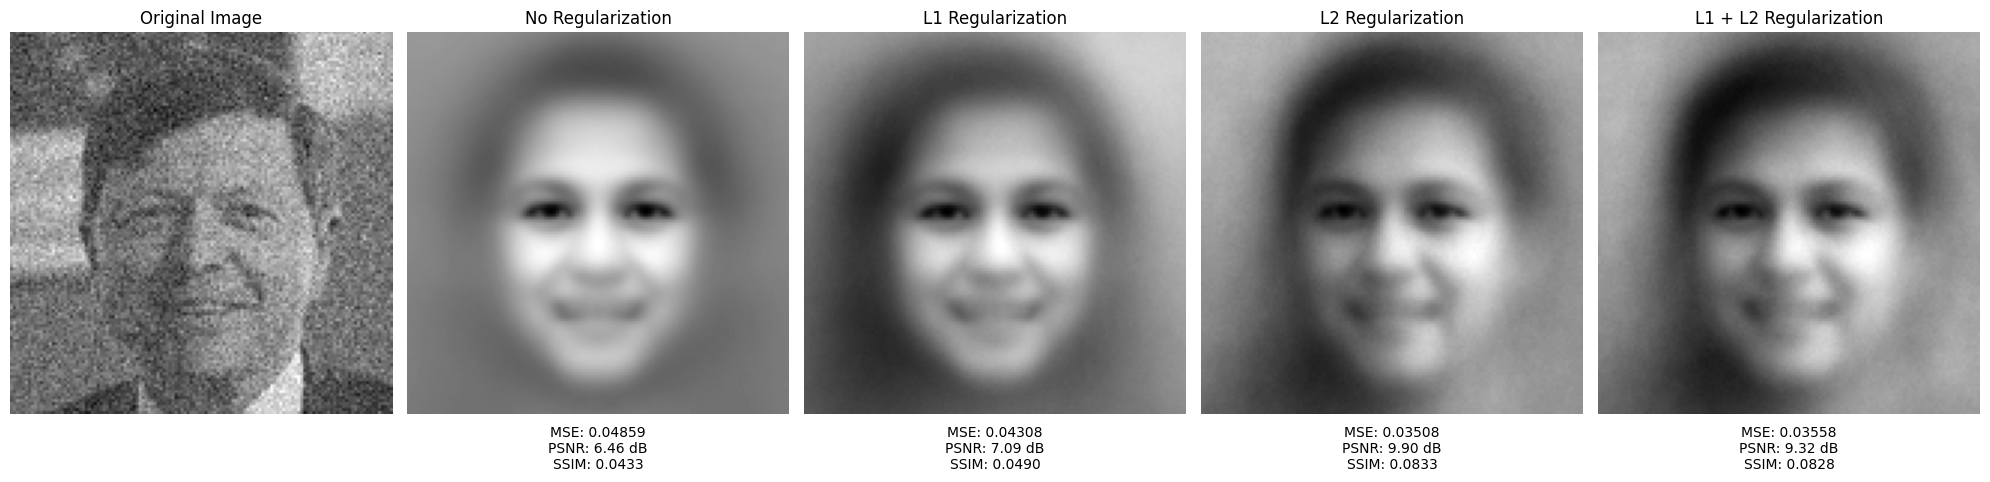

In [19]:
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error

def plot_single_image_reconstructions(image_index, model_paths, titles, test_loader, device, X_DIM, Z_DIM, HIDDEN_SIZE):
    # Get a batch of test images
    images, _ = next(iter(test_loader))  # Get a batch from the test loader
    images = images.to(device)  # Move to device
    
    # Select the image to be reconstructed
    original_img = images[image_index].cpu().numpy()

    # Initialize the plot
    fig, axes = plt.subplots(1, len(model_paths) + 1, figsize=(20, 5))
    
    # Plot the original image
    axes[0].imshow(original_img[0], cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Original Image')
    
    for i, (model_path, title) in enumerate(zip(model_paths, titles), start=1):
        # Load and evaluate the model
        vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
        vae.load_state_dict(torch.load(model_path))
        vae.eval()
        
        # Reconstruct the image
        with torch.no_grad():
            img_tensor = images[image_index].unsqueeze(0).to(device)
            img_flattened = img_tensor.view(img_tensor.size(0), -1)
            vae_samples = vae(img_flattened)
            
            # If vae_samples is a tuple, extract the relevant tensor
            if isinstance(vae_samples, tuple):
                vae_samples = vae_samples[0]
            
            vae_samples_reshaped = vae_samples.view(-1, 128, 128).cpu().numpy()[0]
        
        # Convert images and VAE samples to numpy arrays
        original_img_float = original_img[0]  # Remove channel dimension
        vae_sample_img_float = vae_samples_reshaped
        
        # Calculate MSE, SSIM, and PSNR
        mse_value = mean_squared_error(original_img_float.flatten(), vae_sample_img_float.flatten())
        psnr_value = psnr(original_img_float, vae_sample_img_float, data_range=vae_sample_img_float.max() - vae_sample_img_float.min())
        ssim_value = ssim(original_img_float, vae_sample_img_float, data_range=vae_sample_img_float.max() - vae_sample_img_float.min())
        
        # Plot reconstructed image
        axes[i].imshow(vae_sample_img_float, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(title)
        
        # Add MSE, PSNR, and SSIM text without additional gap
        axes[i].text(0.5, -0.03, 
                     f'MSE: {mse_value:.5f}\nPSNR: {psnr_value:.2f} dB\nSSIM: {ssim_value:.4f}', 
                     ha='center', va='top', transform=axes[i].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
    
    plt.tight_layout()
    plt.show()

import torch
from torch.utils.data import DataLoader

# Define your model paths and titles
model_paths = [
    "vae_best_noisy_{'lambda_l1': 0.0, 'lambda_l2': 0.0, 'use_l1': False, 'use_l2': False}.pth",
    "vae_best_noisy_{'lambda_l1': 0.0, 'lambda_l2': 1e-05, 'use_l1': False, 'use_l2': True}.pth",
    "vae_best_noisy_{'lambda_l1': 1e-05, 'lambda_l2': 0.0, 'use_l1': True, 'use_l2': False}.pth",
    "vae_best_noisy_{'lambda_l1': 1e-05, 'lambda_l2': 1e-05, 'use_l1': True, 'use_l2': True}.pth"
]
titles = ["No Regularization", "L1 Regularization", "L2 Regularization" ,"L1 + L2 Regularization"]

# Choose an image index from the test loader
image_index = 0  # Change this index as needed

# Call the function
plot_single_image_reconstructions(
    image_index=image_index,
    model_paths=model_paths,
    titles=titles,
    test_loader=test_loader_noisy,
    device=device,
    X_DIM=X_DIM,
    Z_DIM=Z_DIM,
    HIDDEN_SIZE=HIDDEN_SIZE
)
